In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Clone the model 
!git clone https://github.com/ultralytics/yolov5  

# install dependencies
!pip install -U -r yolov5/requirements.txt  

Cloning into 'yolov5'...
remote: Enumerating objects: 12264, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 12264 (delta 18), reused 22 (delta 13), pack-reused 12229
Receiving objects: 100% (12264/12264), 11.99 MiB | 21.06 MiB/s, done.
Resolving deltas: 100% (8488/8488), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.6 MB/s 
     |████████████████████████████████| 60.9 MB 1.2 MB/s 
     |████████████████████████████████| 3.1 MB 51.5 MB/s 
     |████████████████████████████████| 596 kB 56.4 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 38.1 MB 457 kB/s 
     |████████████████████████████████| 1.0 MB 49.5 MB/s 
     |████████████████████████████████| 5.8 MB 41.2 MB/s 
     |████████████████████████████████| 793 kB 51.3 MB/s 
     |█████████████████████████████

In [3]:
# access the yolov5 folder and show the model's architecture
%cd /content/yolov5
%cat /content/yolov5/models/yolov5s.yaml

/content/yolov5
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4],

In [4]:
import torch
from IPython.display import Image  # for displaying images
#from utils.google_utils import gdrive_download  # for downloading models/datasets

# check if we're using torch with GPU
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [5]:
# You need to sign up in roboflow to get the key and then you can use the dataset
!curl -L "https://app.roboflow.com/ds/3gu6Dr9YhF?key=pqSM4SdbJW" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !ls

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: train/labels/rotro_3_jpg.rf.9d18d15b9ff048f9e7f5085c0a8d641d.txt  
 extracting: train/labels/rotro_3_jpg.rf.9e59eb9528c20462317c079f9e0998c3.txt  
 extracting: train/labels/rotro_3_jpg.rf.a1456e795d82737c6b8060f9adbd8f9e.txt  
 extracting: train/labels/rotro_3_jpg.rf.a1fc1bd0aedc7aa221b4082a87621879.txt  
 extracting: train/labels/rotro_3_jpg.rf.a3659e936e9d7ebe0fb17093ec8477d0.txt  
 extracting: train/labels/rotro_3_jpg.rf.a483434a2db5b321d0d8a04cb1989024.txt  
 extracting: train/labels/rotro_3_jpg.rf.a493e65fb23c370c7e0a51b3e16e29d9.txt  
 extracting: train/labels/rotro_3_jpg.rf.a72b06a8e56e5e6bfba73c38d7a2867e.txt  
 extracting: train/labels/rotro_3_jpg.rf.a740071f7bd5bf49b3cbdd7e0f8eb6f0.txt  
 extracting: train/labels/rotro_3_jpg.rf.a75e9d2c0ea16a6149a1217ba17982a3.txt  
 extracting: train/labels/rotro_3_jpg.rf.a7a037e0f00b54bf692c1e2f9158df61.txt  
 extracting: train/labels/rotro_3_jpg.rf.a83aa5437d78005460

In [6]:
# visualise the content of data.yaml
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['atendiendo', 'distraido', 'dormido']

In [7]:
# define the number of classes
num_classes = 3

# IPython is a great tool for interactive shells as Notebooks. It comes with 
# many utilities and we will use register_line_cell_magic
# to overwrite a file directly from a Colab cell. Otherwise, we would need to 
# download and upload the file. We define writetemplate to customize iPython 
# writefile 
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
# change the location of the training and validation subsets. The rest
# of the file remains equal. 

%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./test/images

nc: 3
names: ['atendiendo', 'distraido', 'dormido']


In [9]:
%cat data.yaml


train: ./train/images
val: ./test/images

nc: 3
names: ['atendiendo', 'distraido', 'dormido']

In [10]:
# change the number of classes defined in the yolo v5 architectures. the rest remains the same. 
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
%cat models/custom_yolov5s.yaml


# parameters
nc: 3  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[

In [12]:
# Since we exported the dataset for Yolo v5, we don't need to resize the images.
# We will train the model for 5 epoch with batch size of 80, however, you can 
# change these parameters to get a better performance
# train.py uses the subsets information from data.yaml. 

%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data './data.yaml' --cfg './models/yolov5s.yaml' --weights '' --name yolov5s_results --cache
#!python train.py --img 416 --batch 16 --epochs 10 --data './data.yaml' --cfg './models/custom_yolov5s.yaml' --weights './runs/train/exp/weights'

/content/yolov5
train: weights=, cfg=./models/yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-253-g75bbaa8 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_

In [32]:
# final weights will be stored by default at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/

!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.30 --source /content/yolov5/test/images/
#!python detect.py --weights /content/drive/MyDrive/datasets/OID/ --img 416 --conf 0.4 --source /content/drive/MyDrive/datasets/OID/Dataset/test

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-253-g75bbaa8 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients
image 1/815 /content/yolov5/test/images/120911685_3406334372777647_5958042774224477816_n_jpg.rf.fbc2823984ff10716d02e908e01e2f87.jpg: 416x416 1 atendiendo, Done. (0.011s)
image 2/815 /content/yolov5/test/images/13247897_1238926916138609_1362606789618374335_o_jpg.rf.b2981529daad779f8d2c0d914518c63f.jpg: 416x416 1 atend

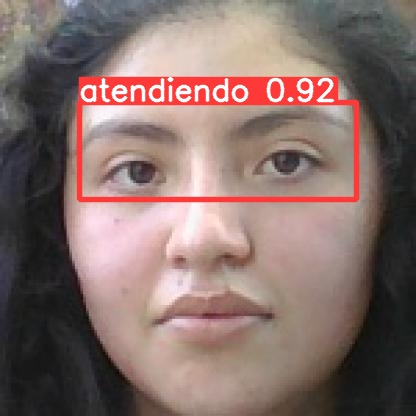

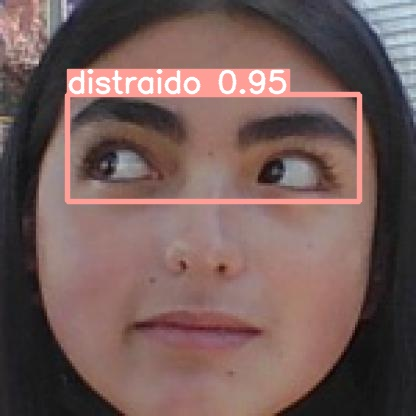

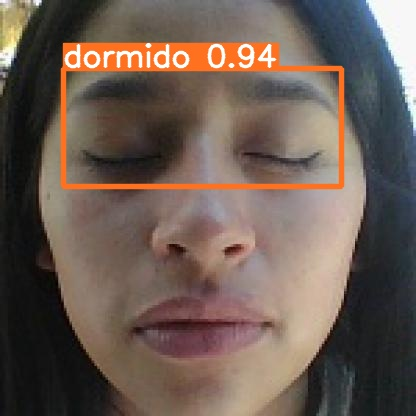

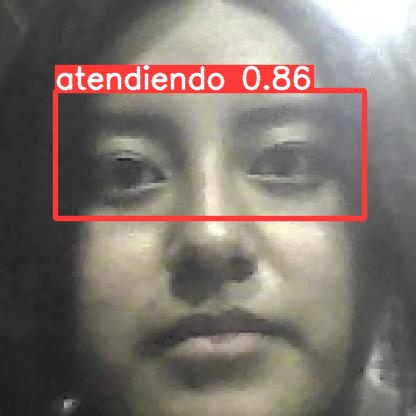

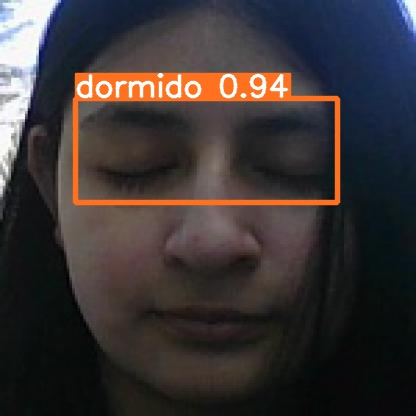

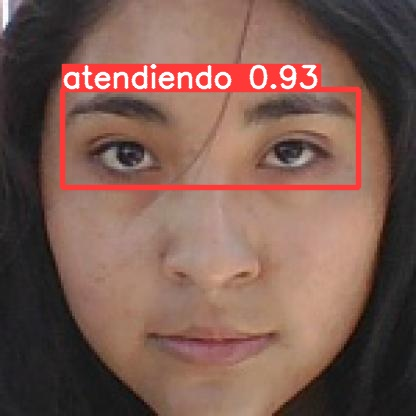

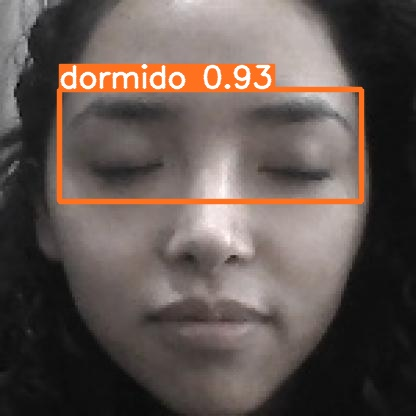

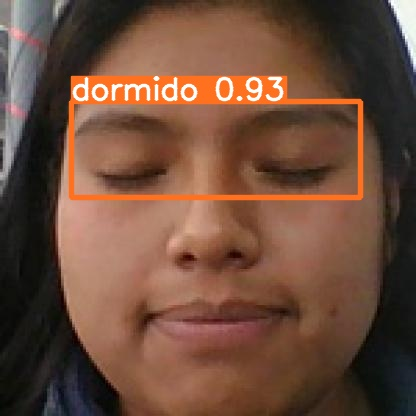

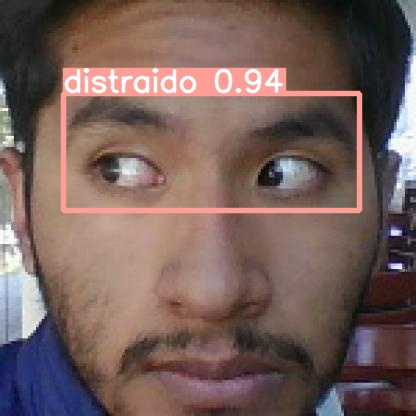

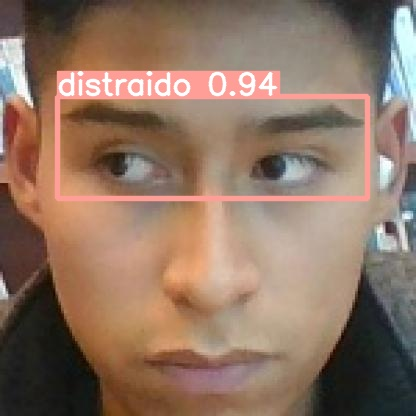

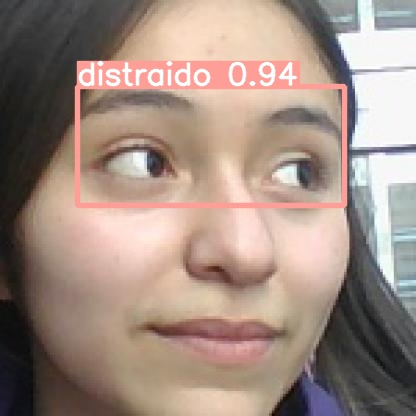

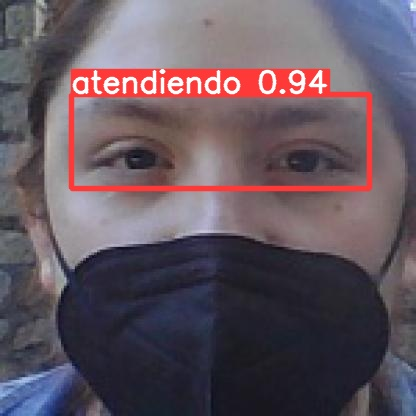

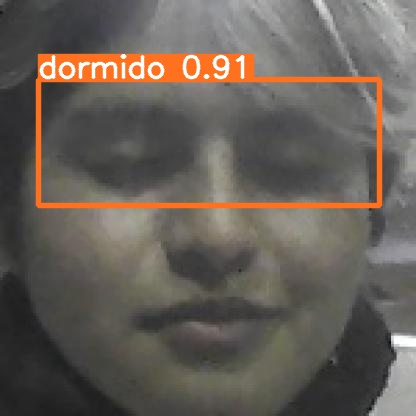

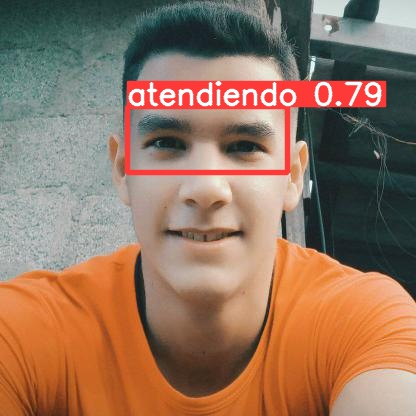

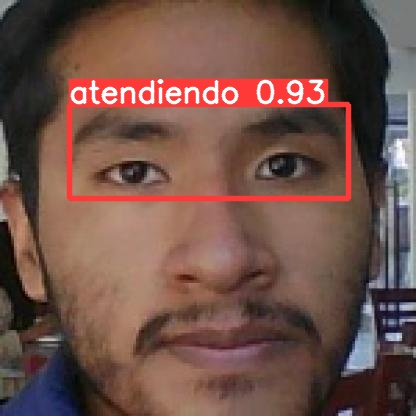

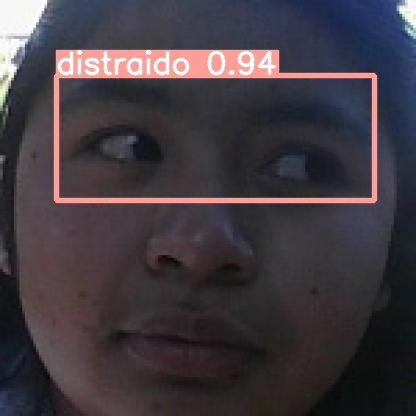

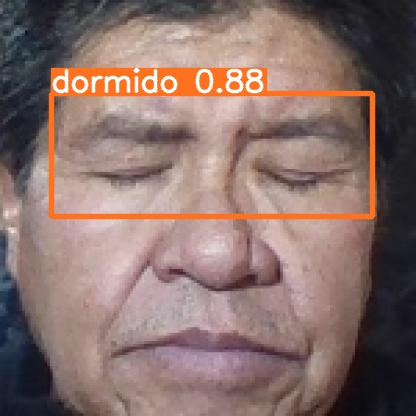

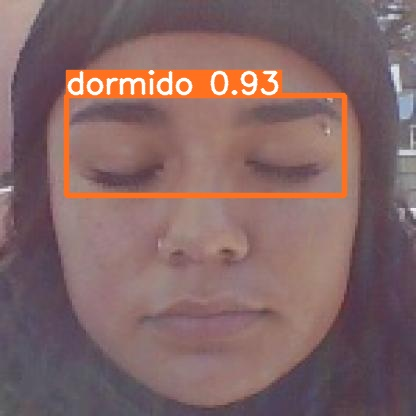

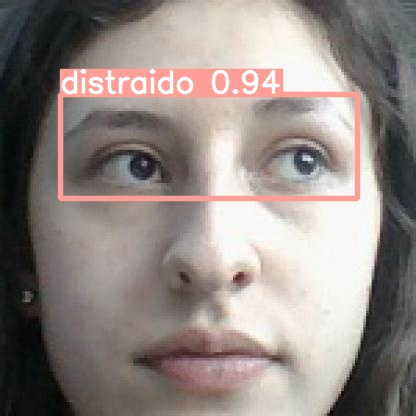

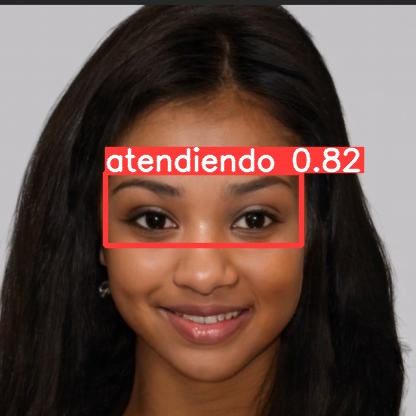

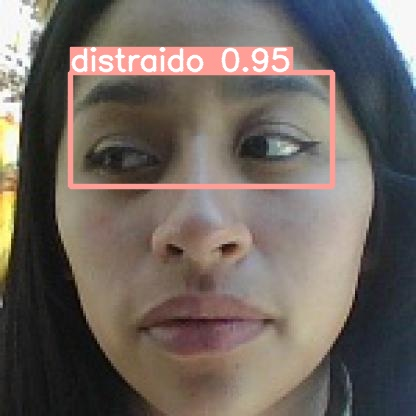

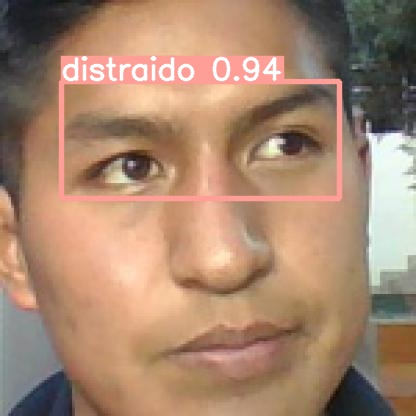

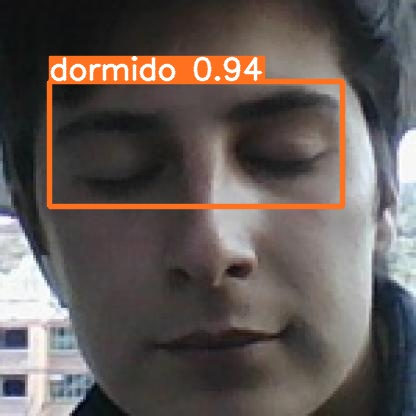

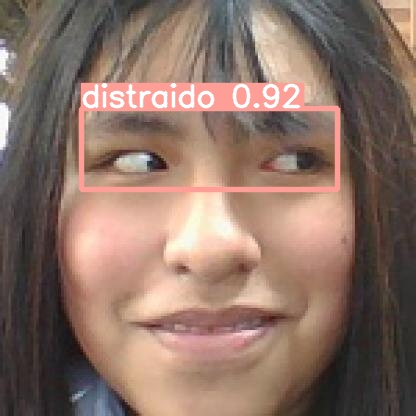

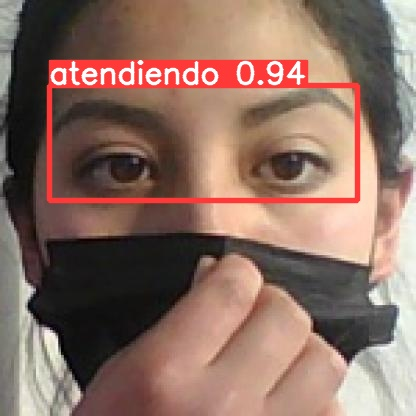

In [34]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/detect/exp6/*.jpg')[:25]:
    display(Image(filename=image))
    print("\n")

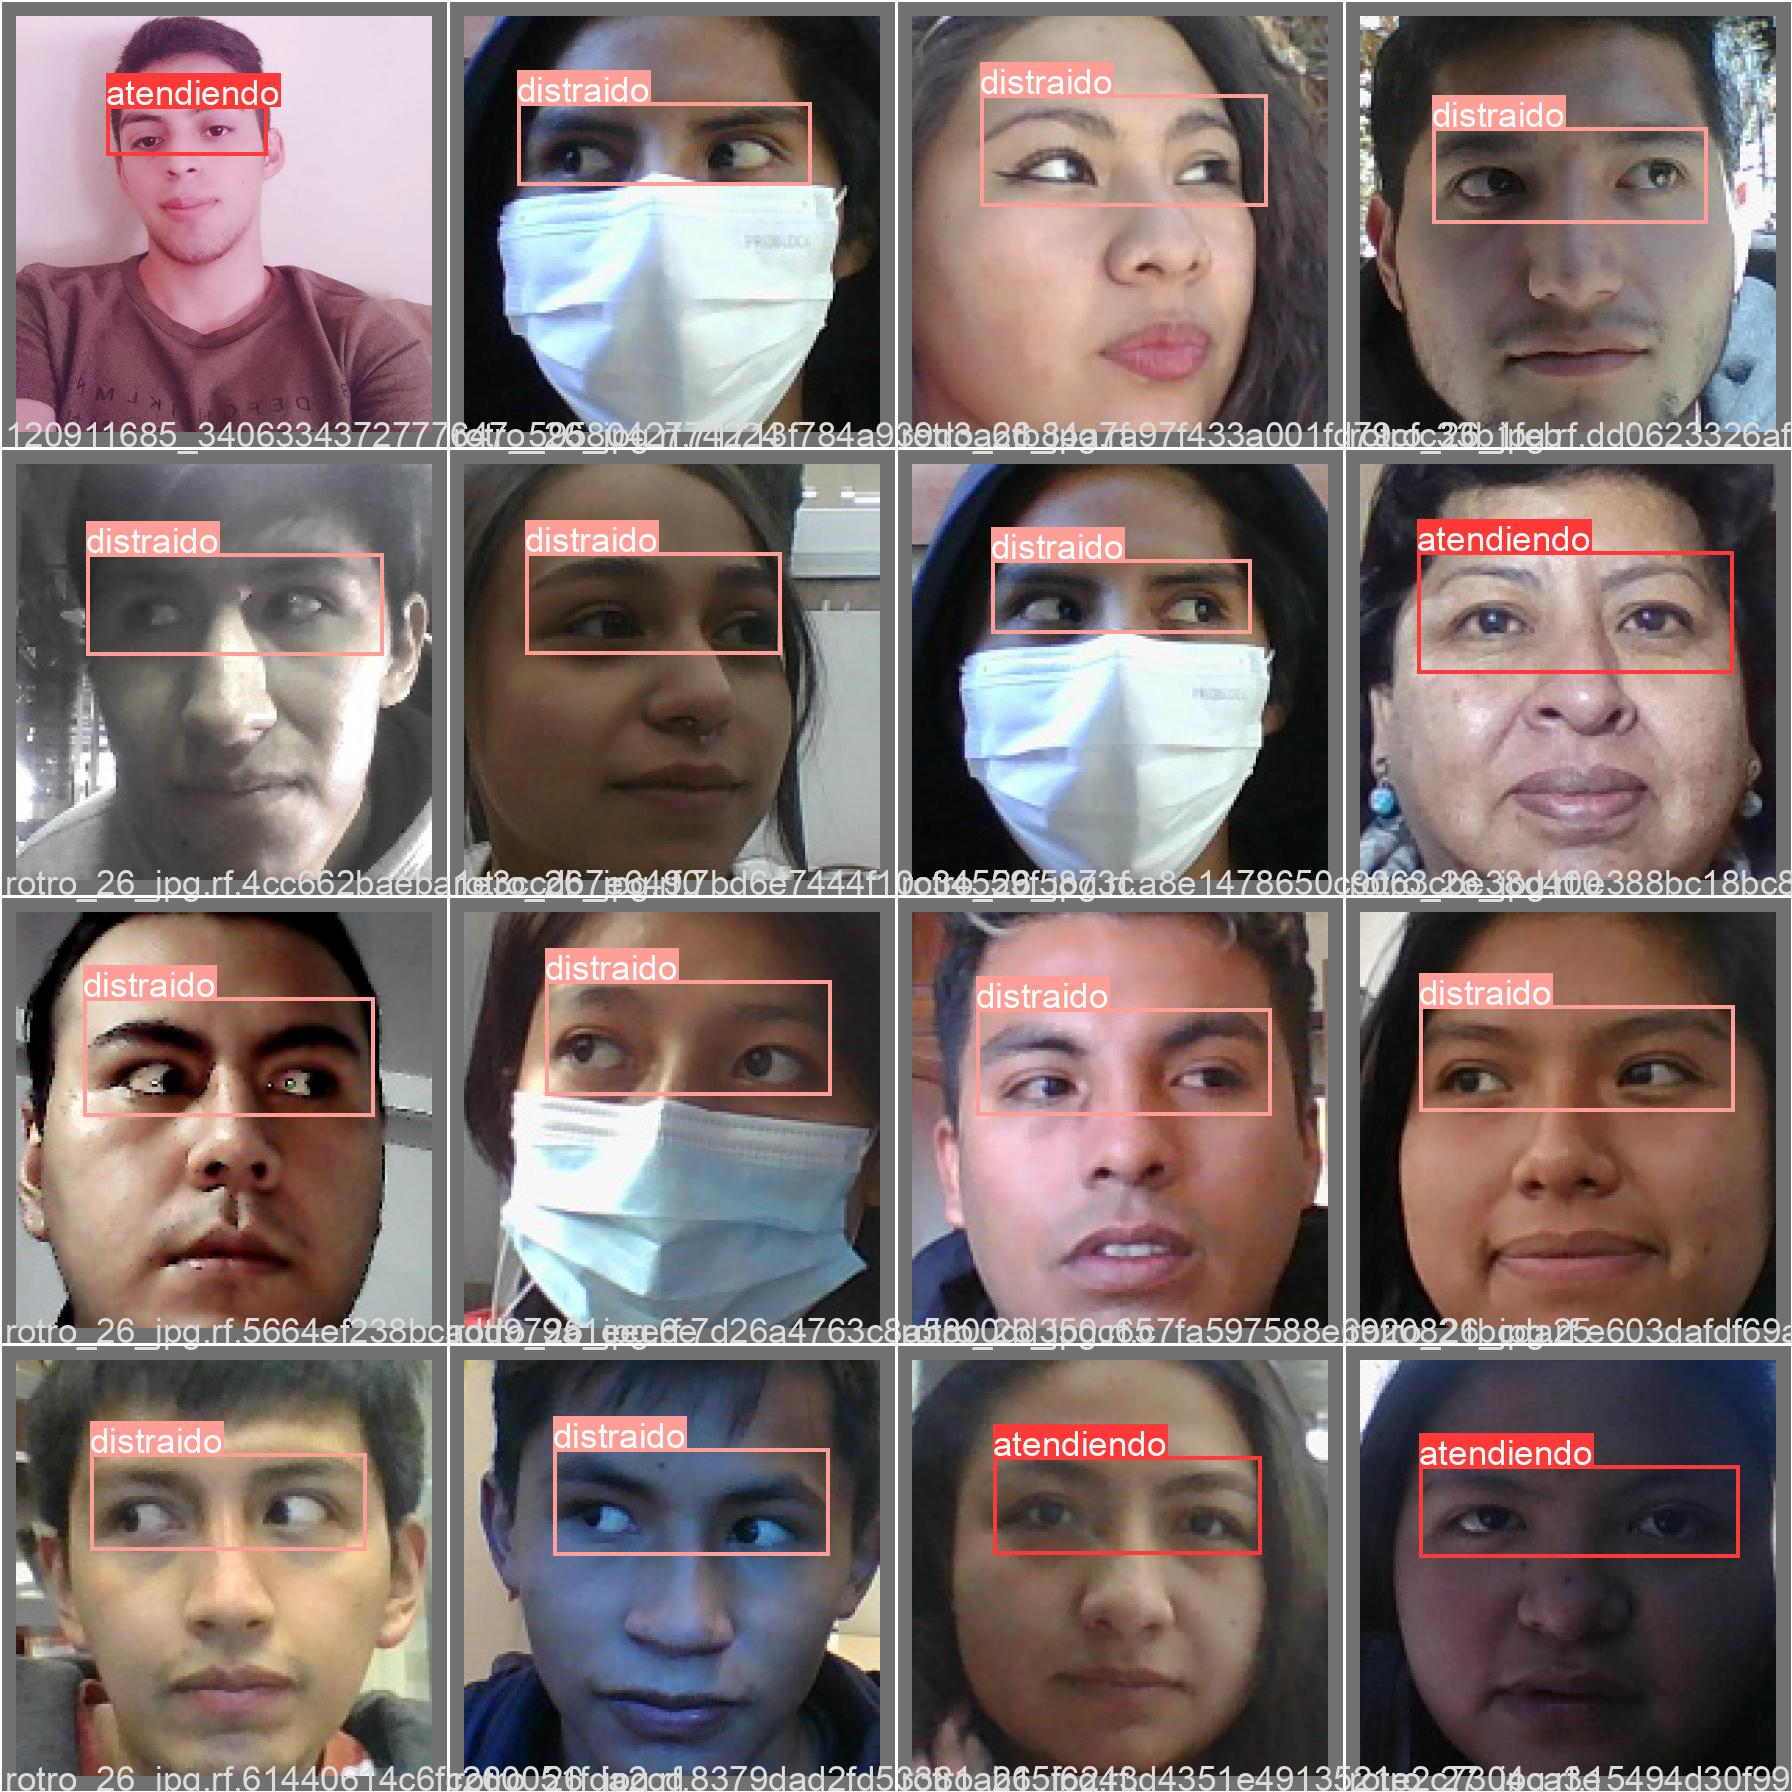

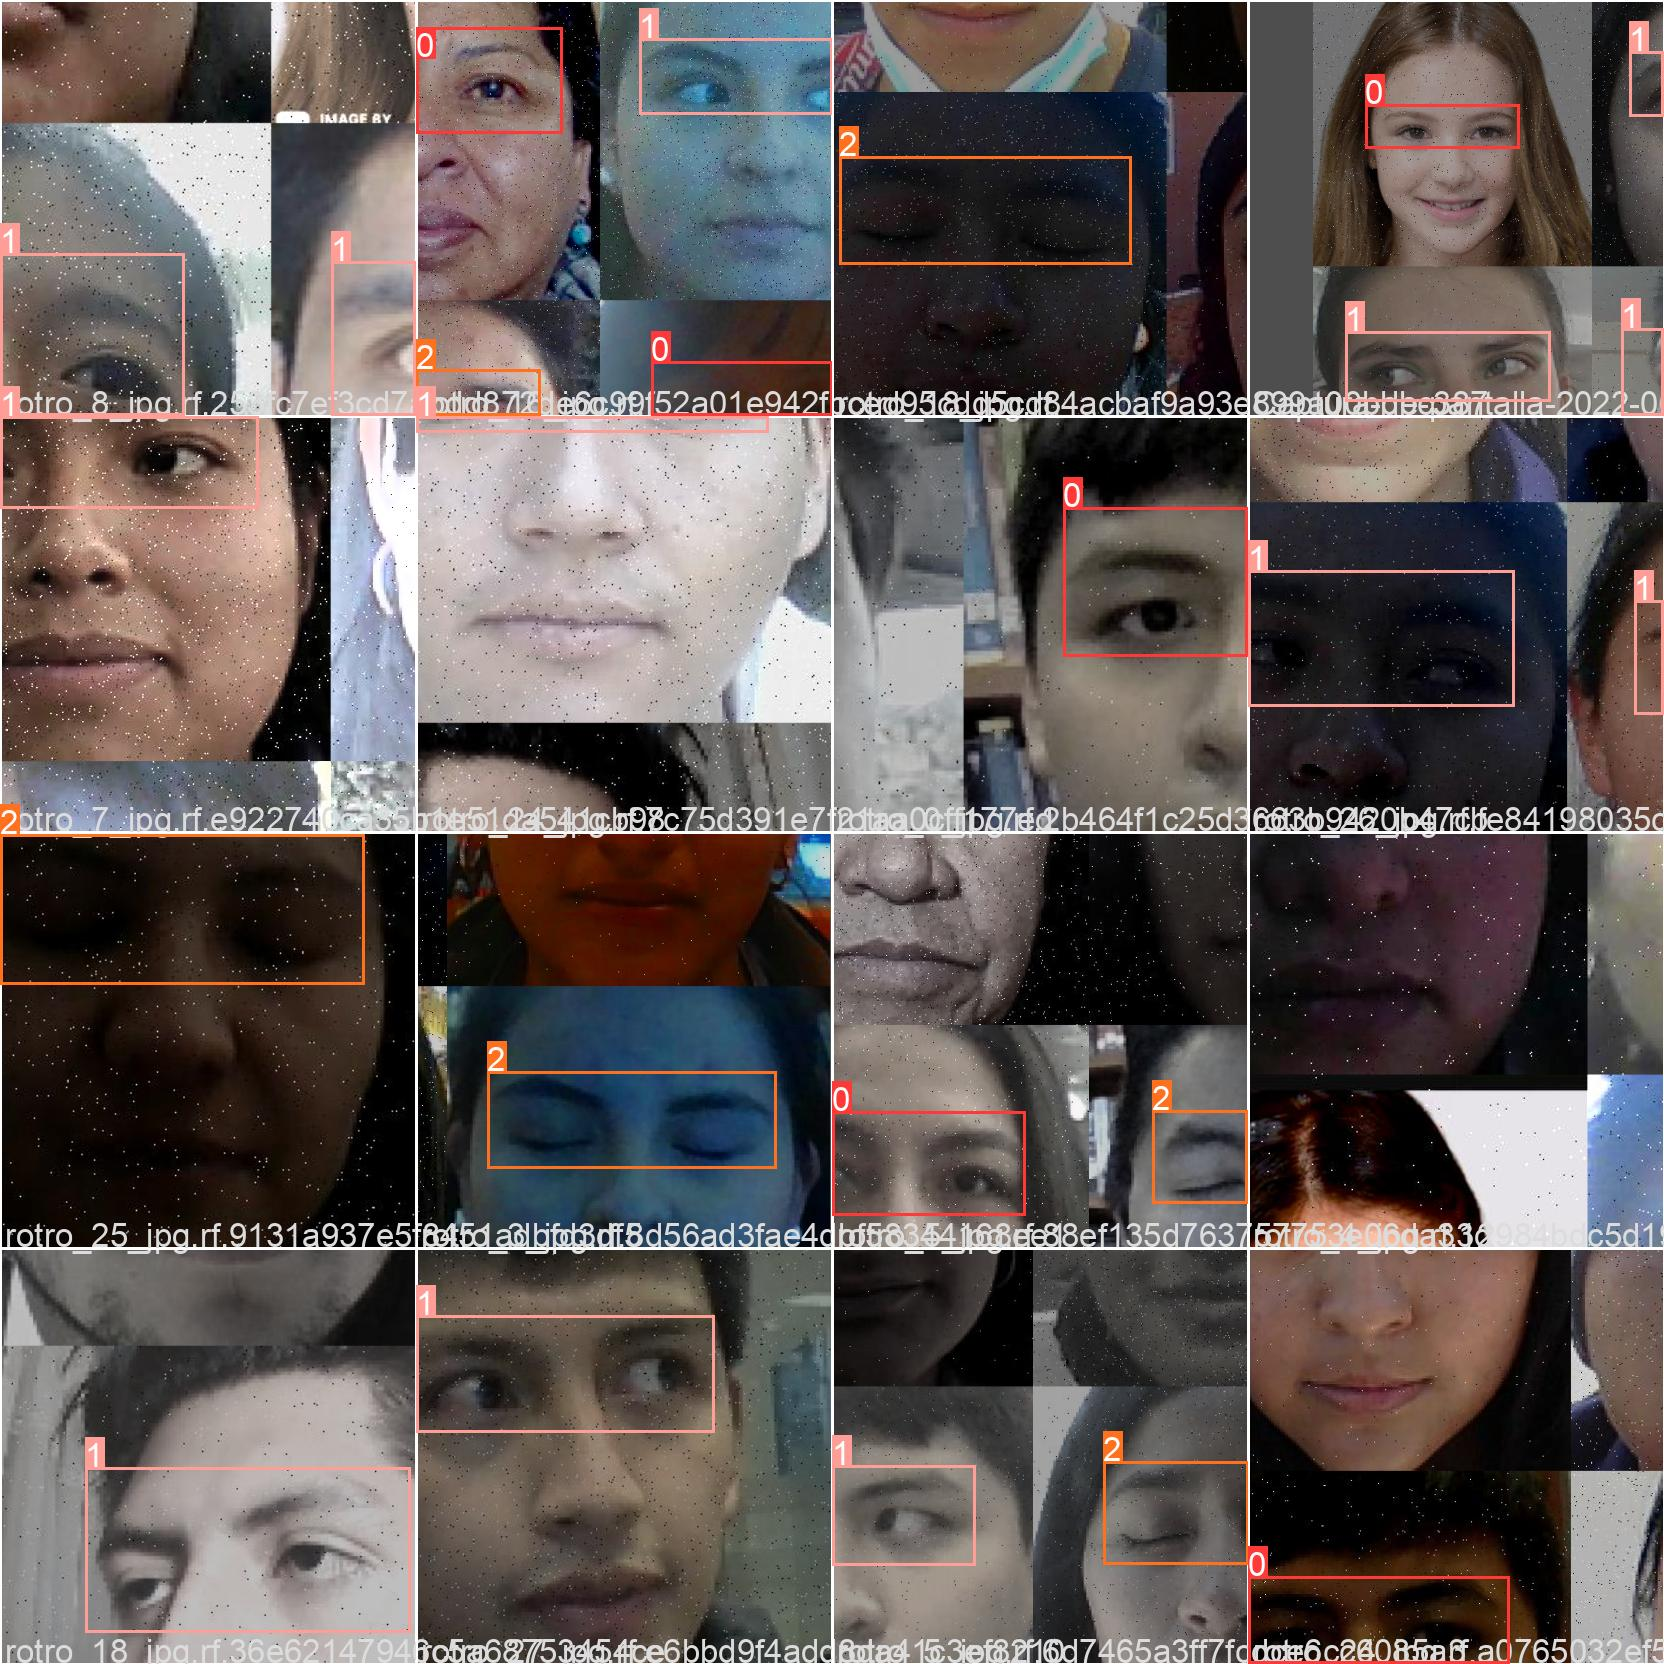

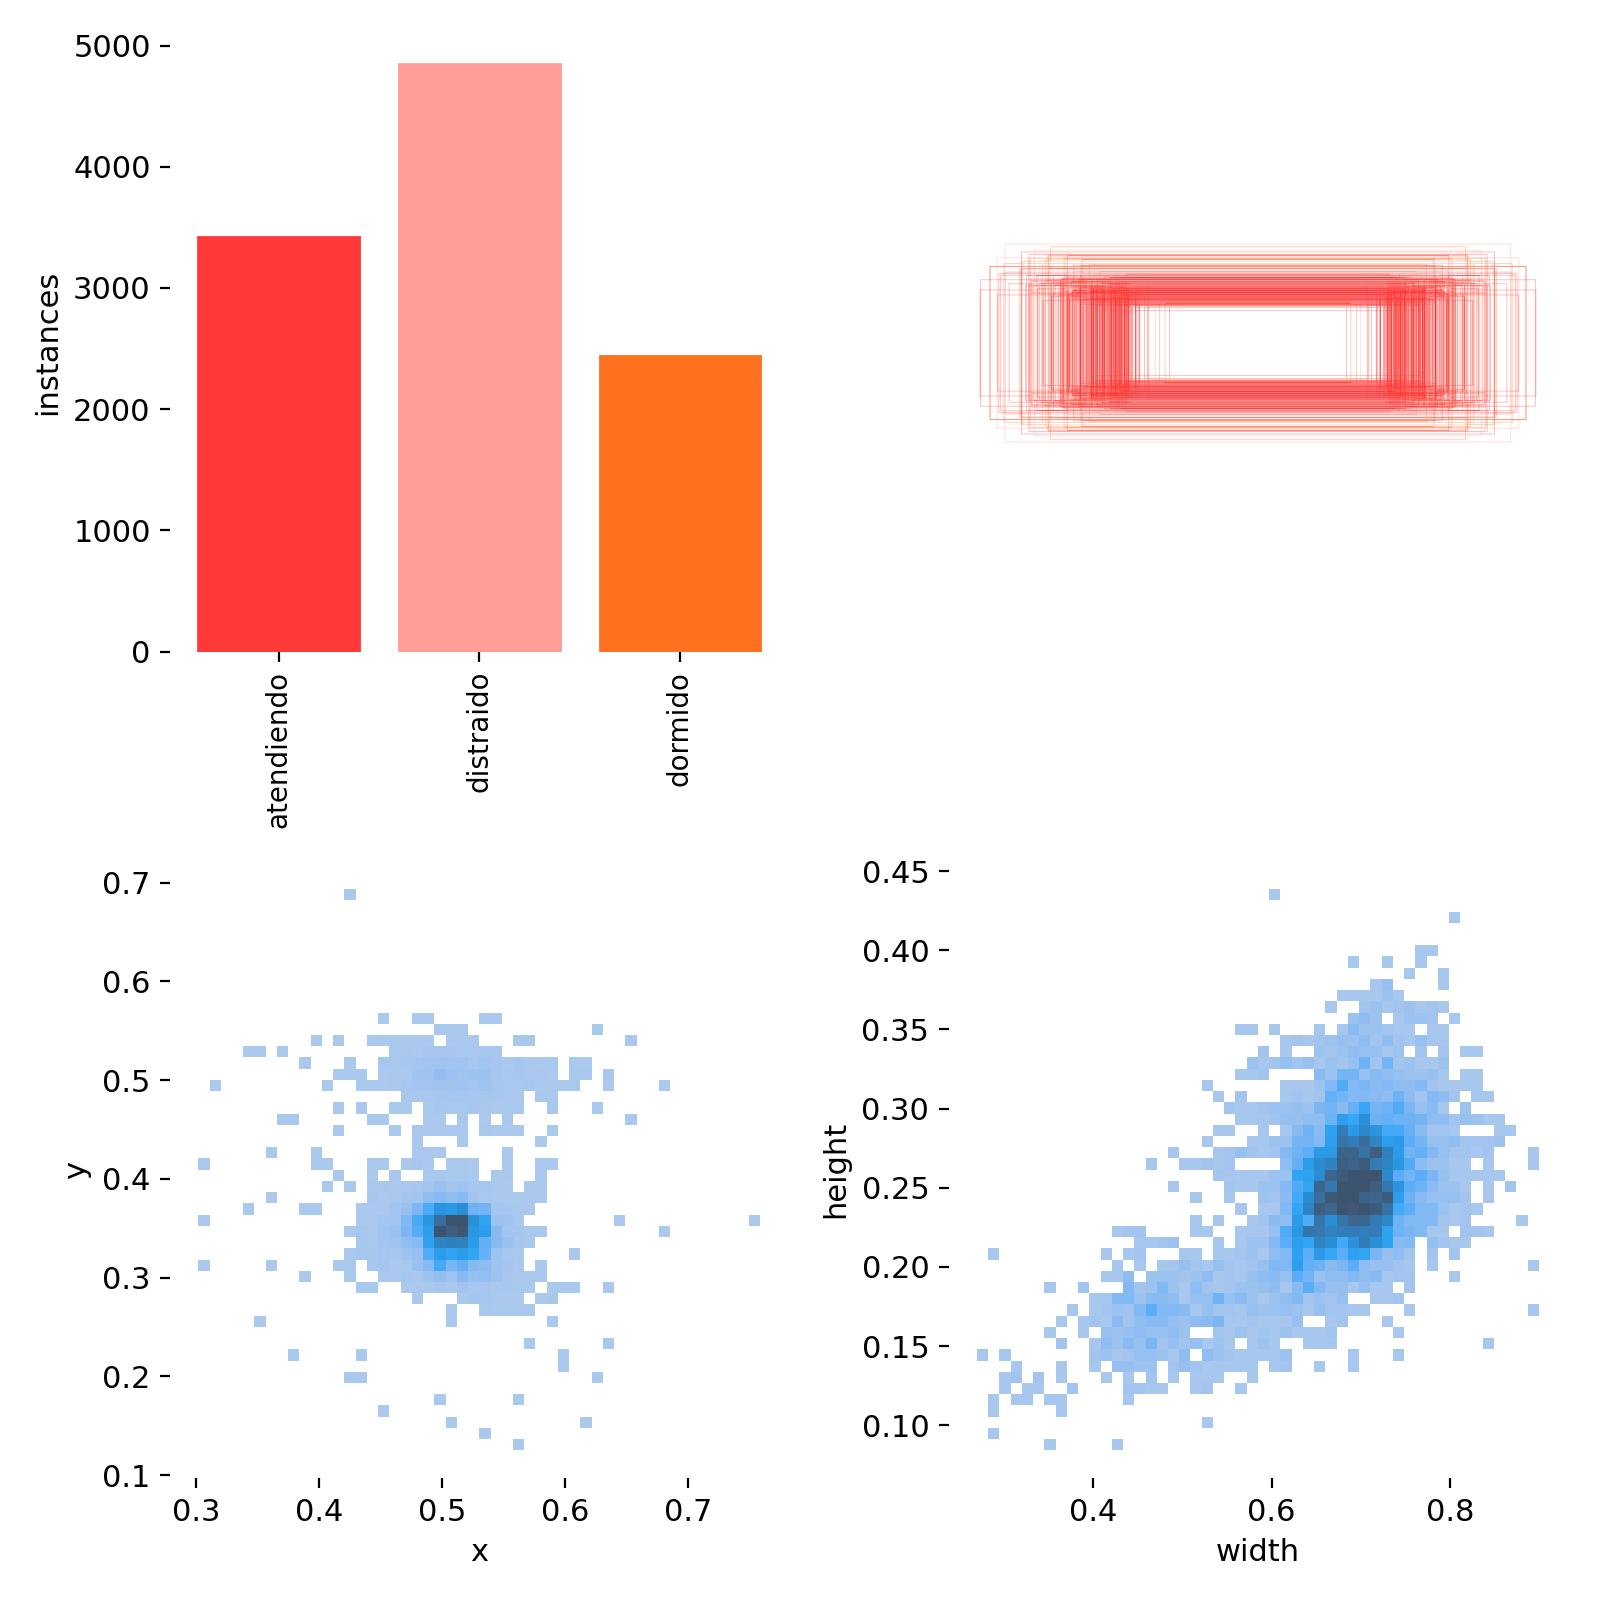

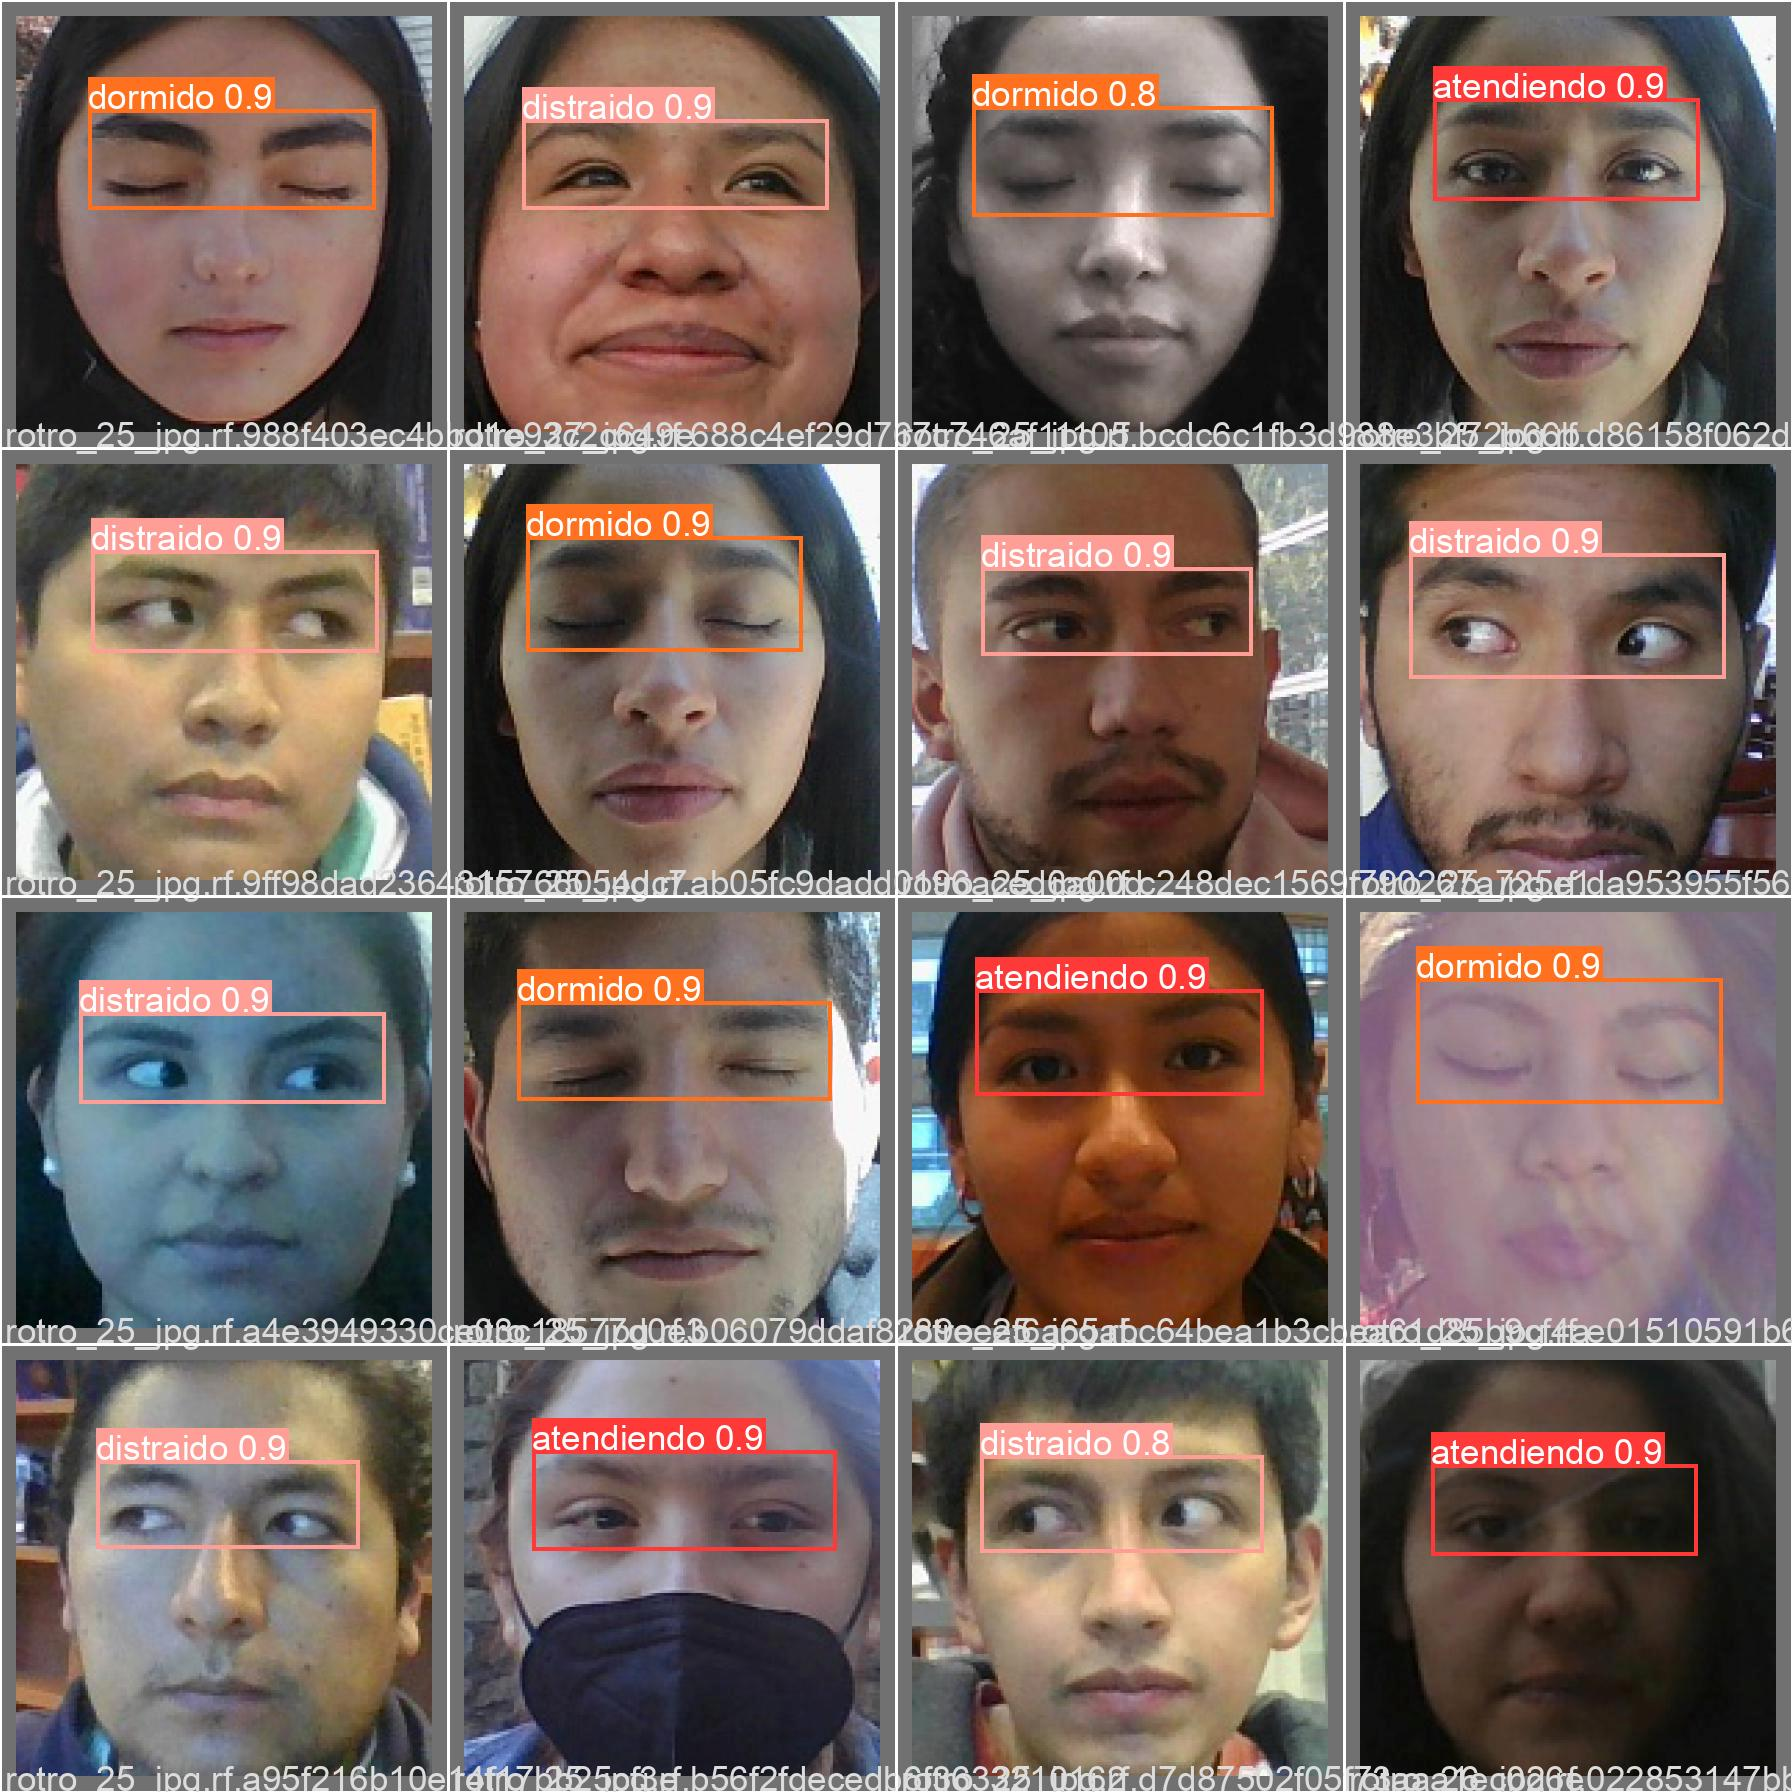

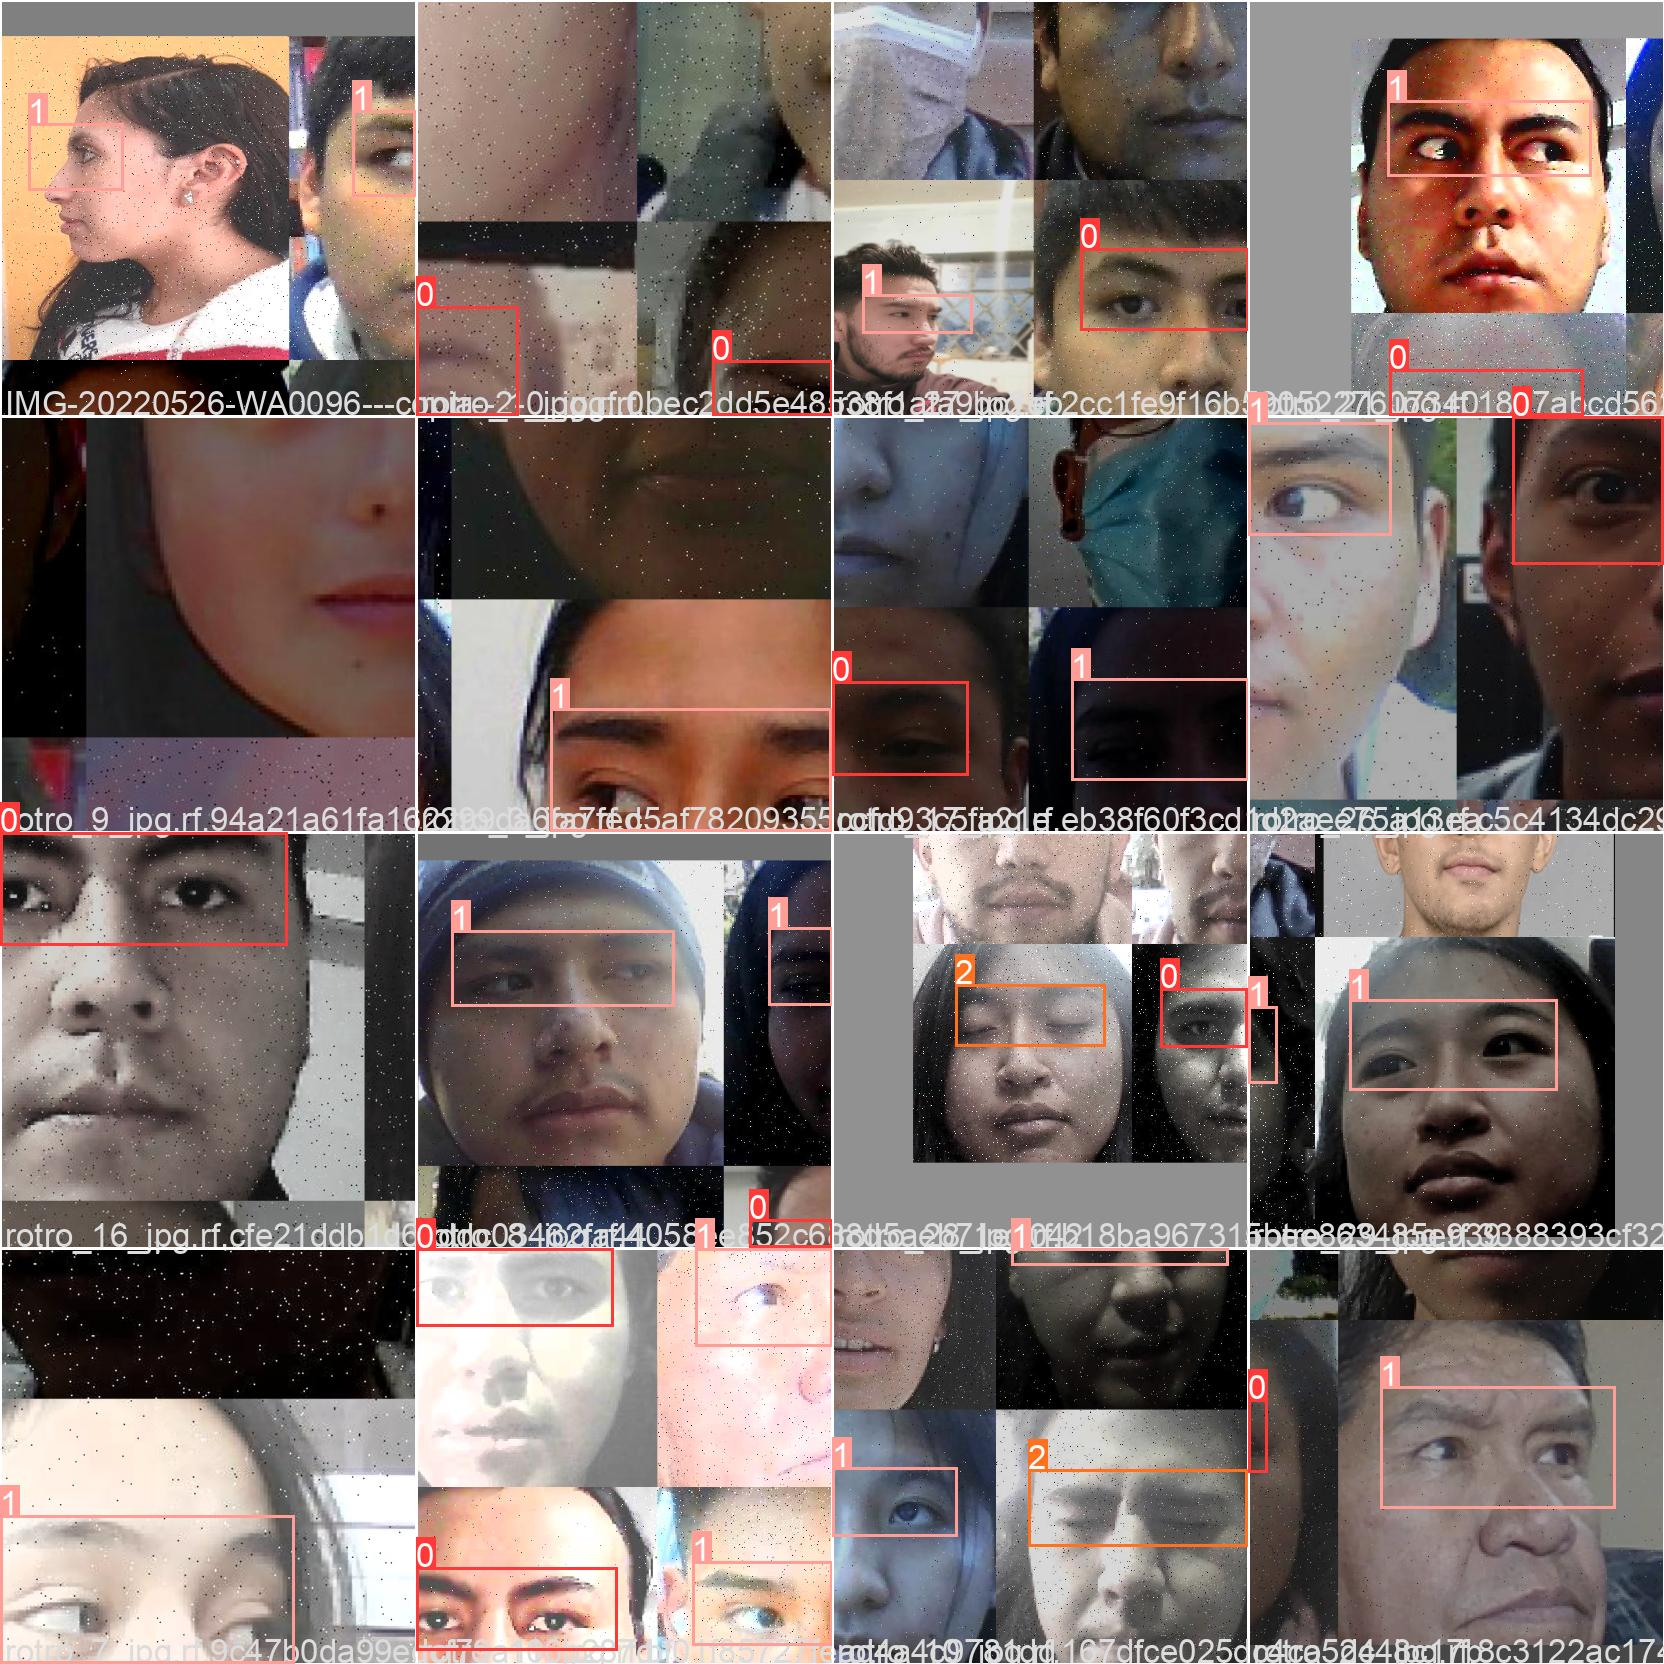

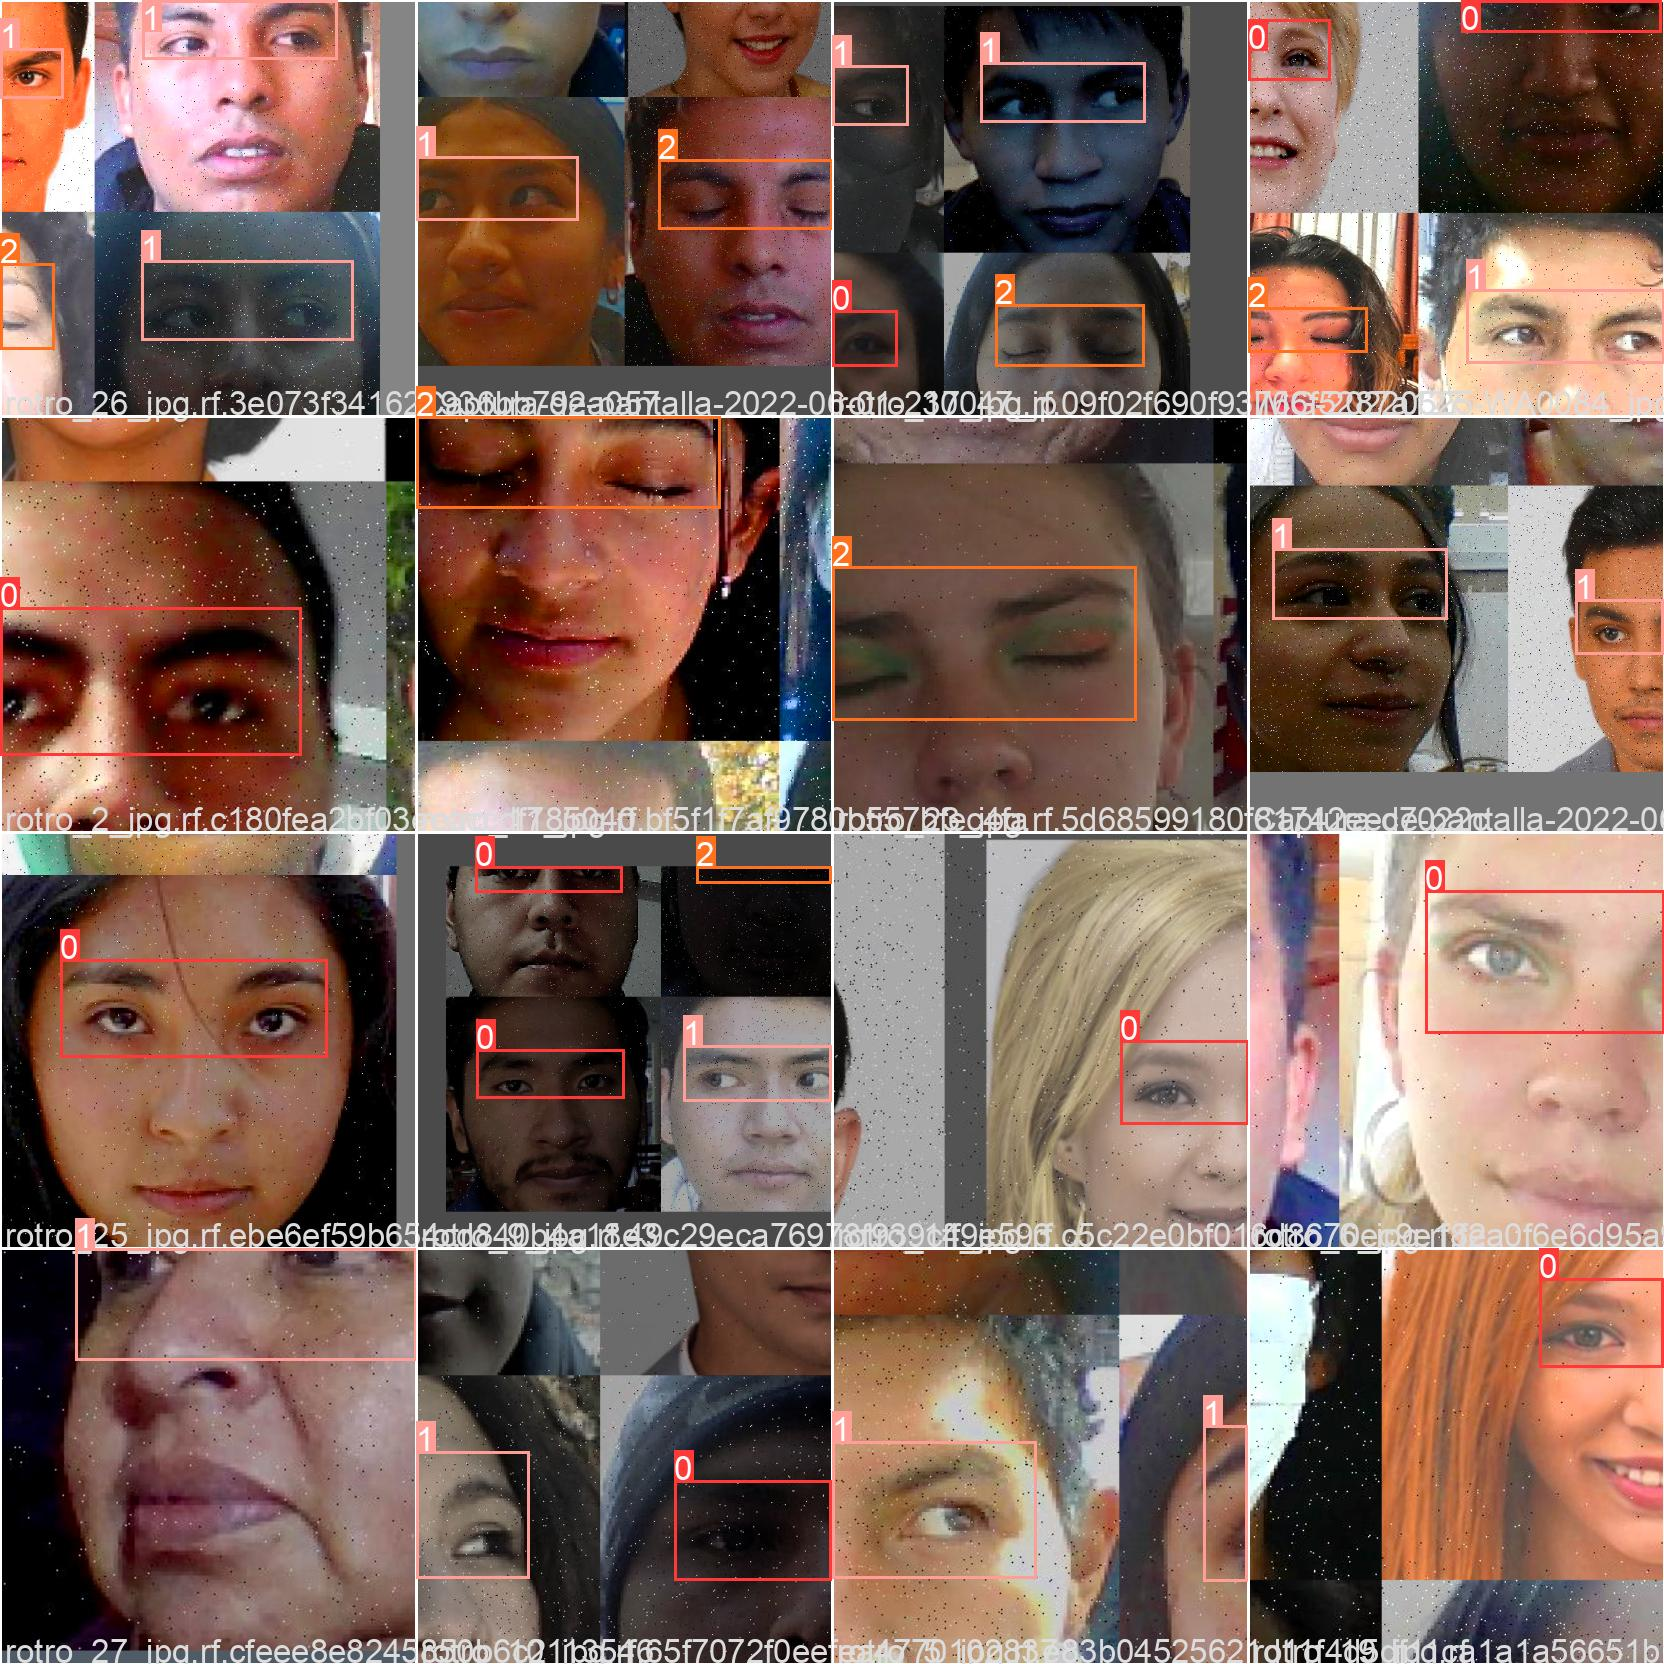

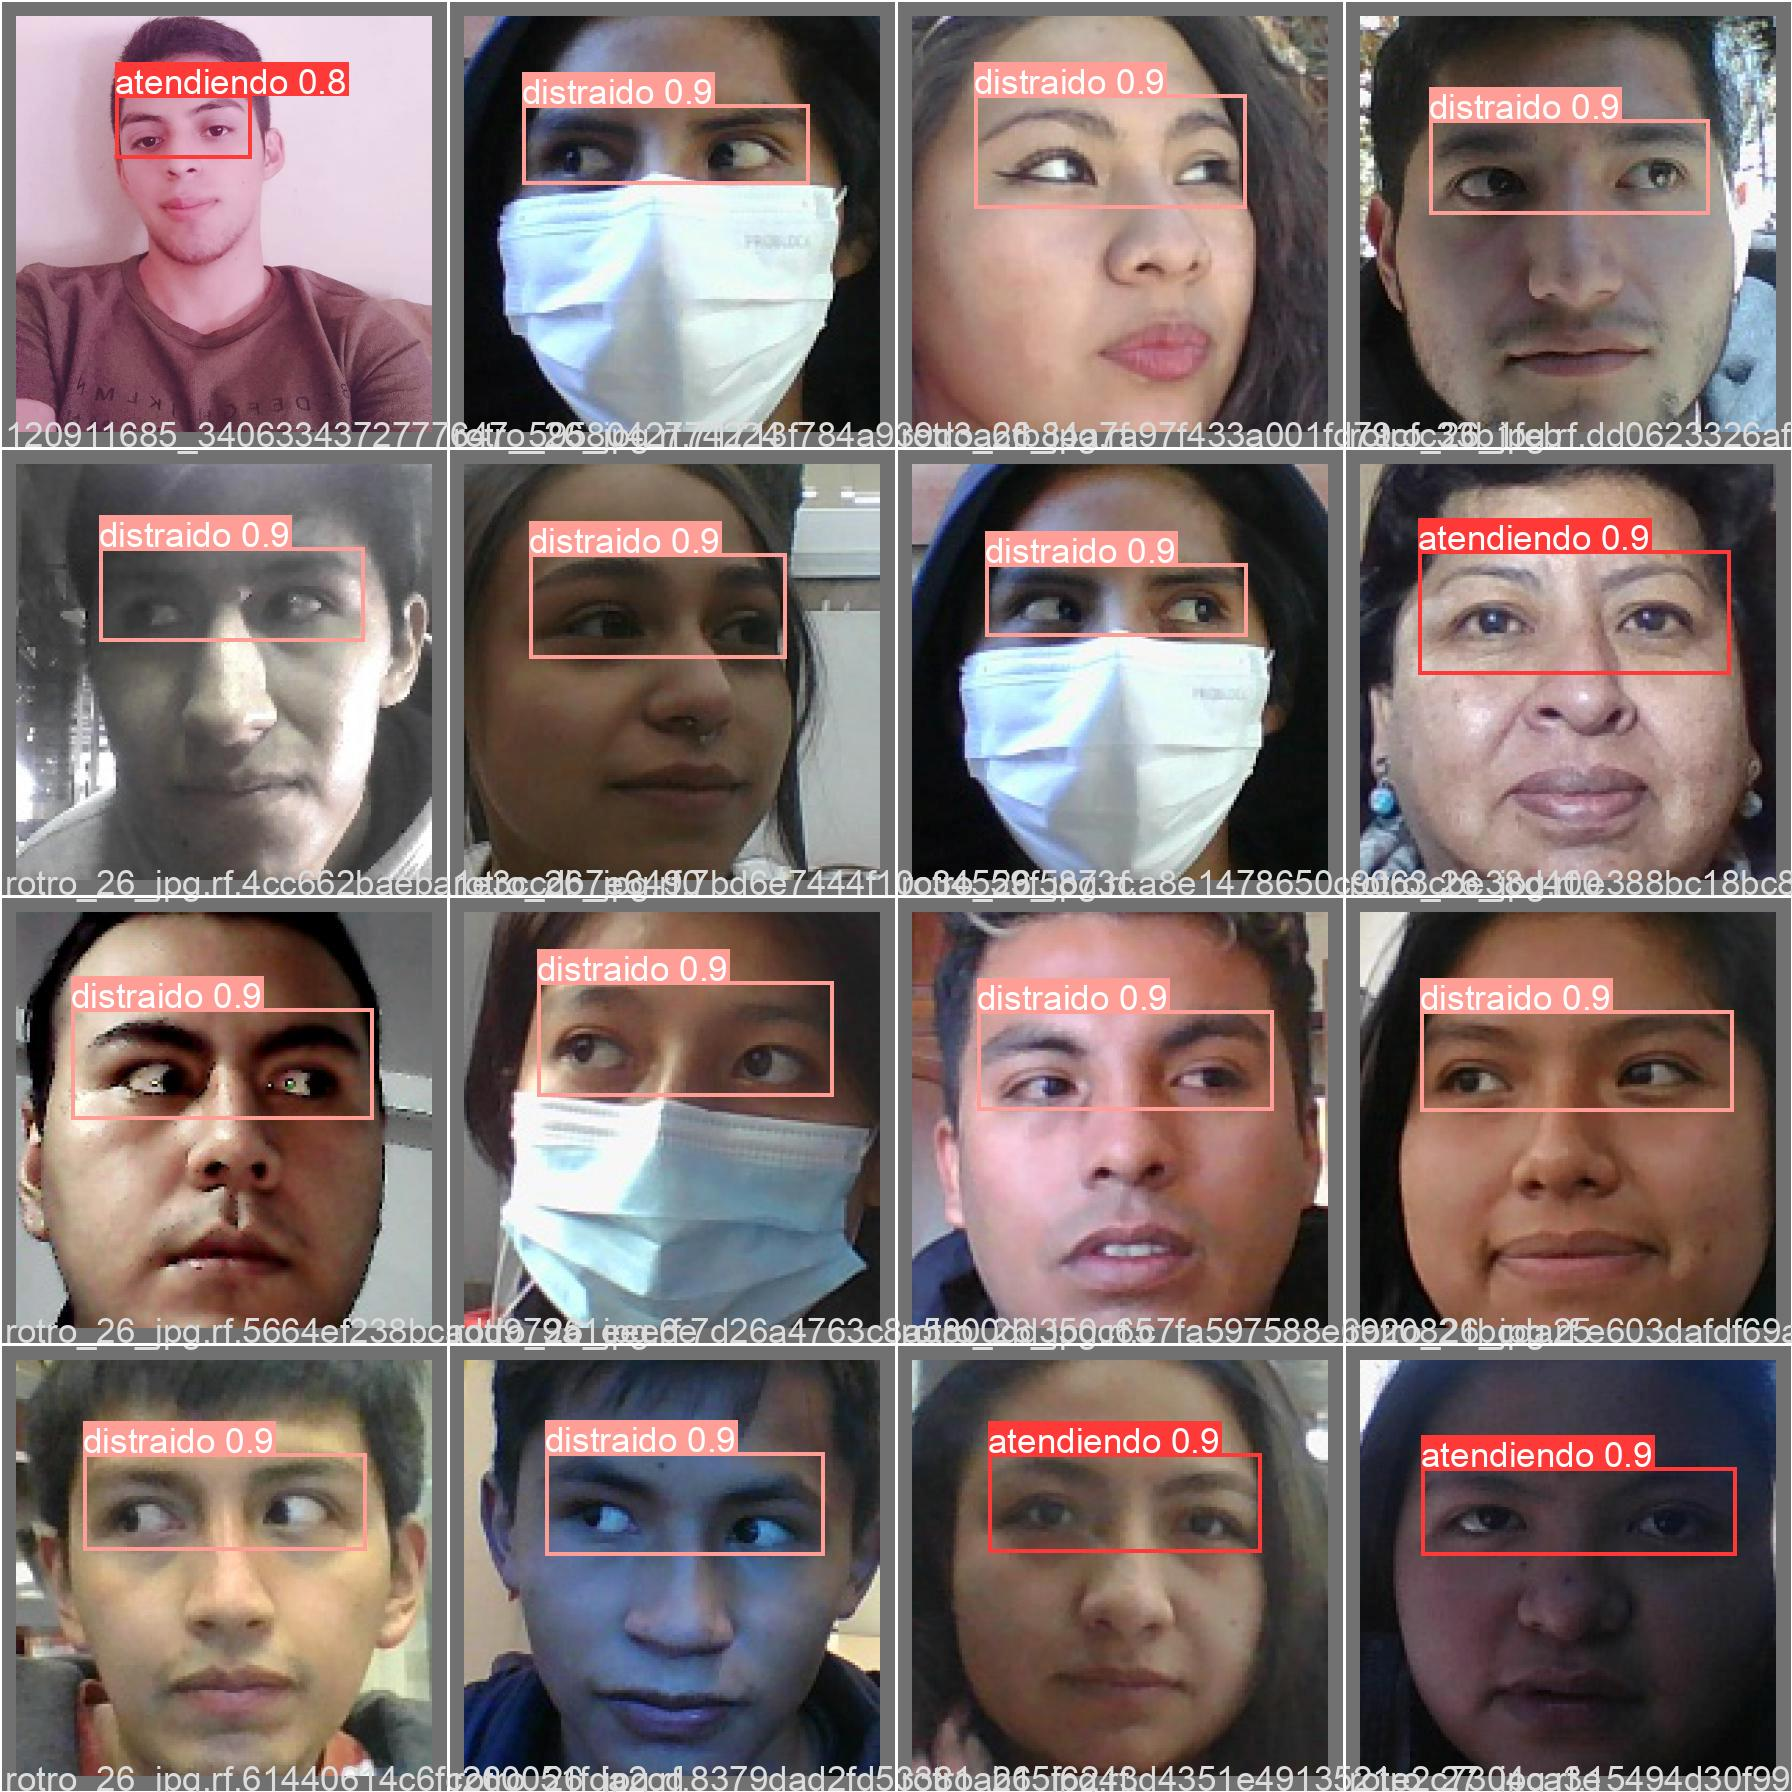

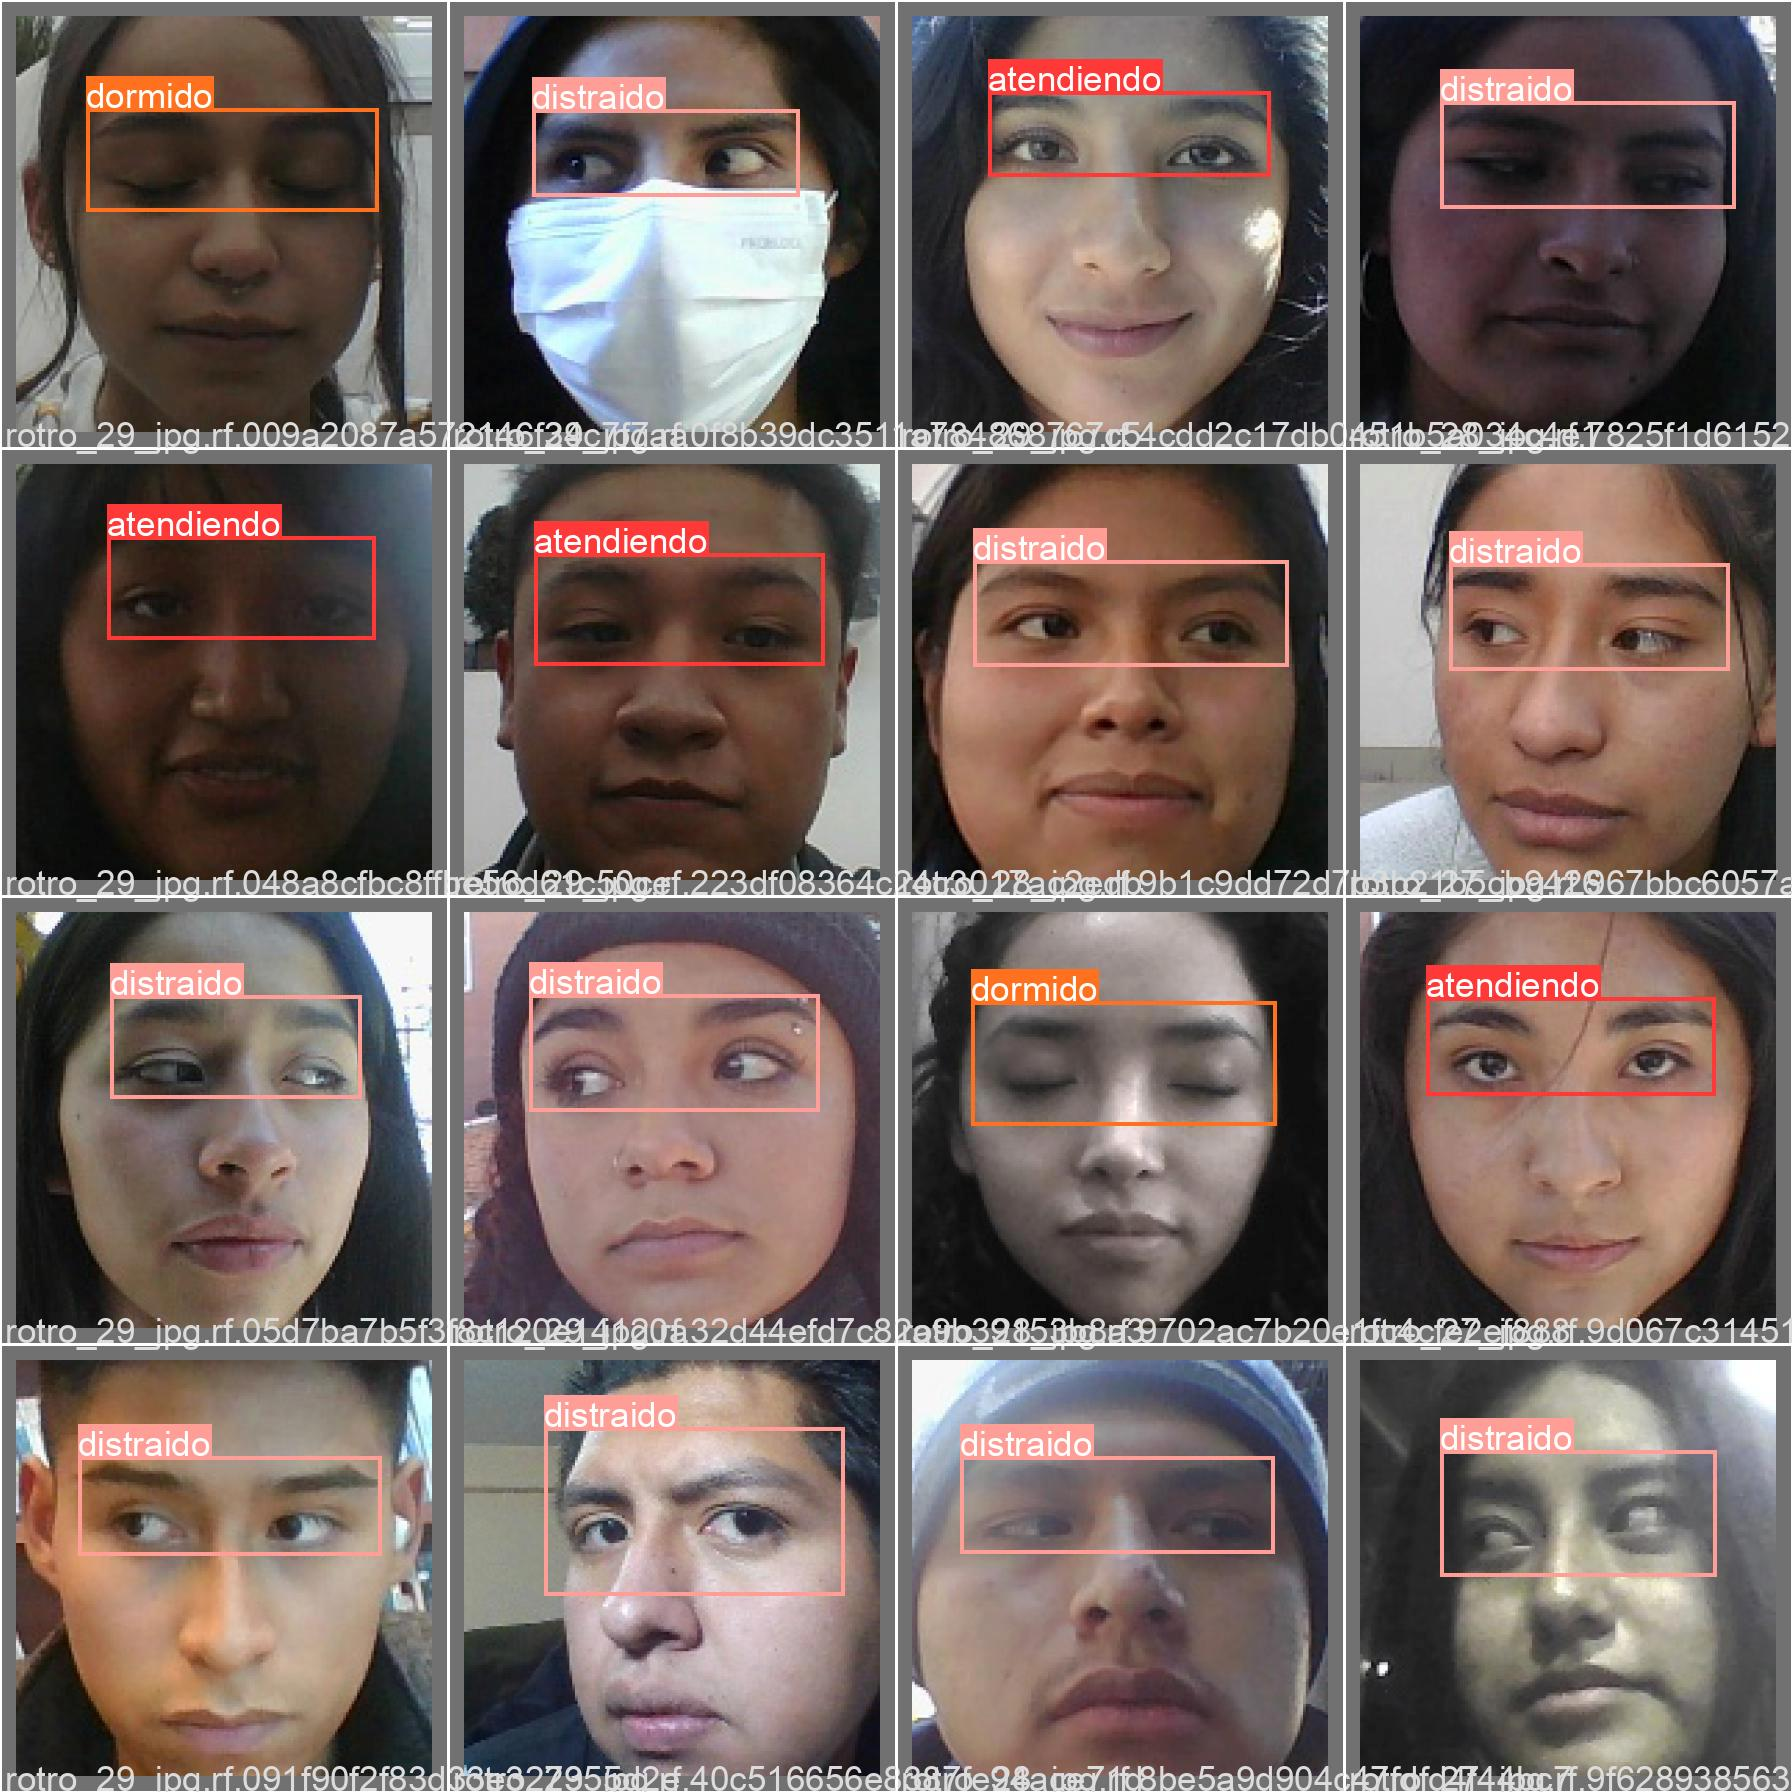

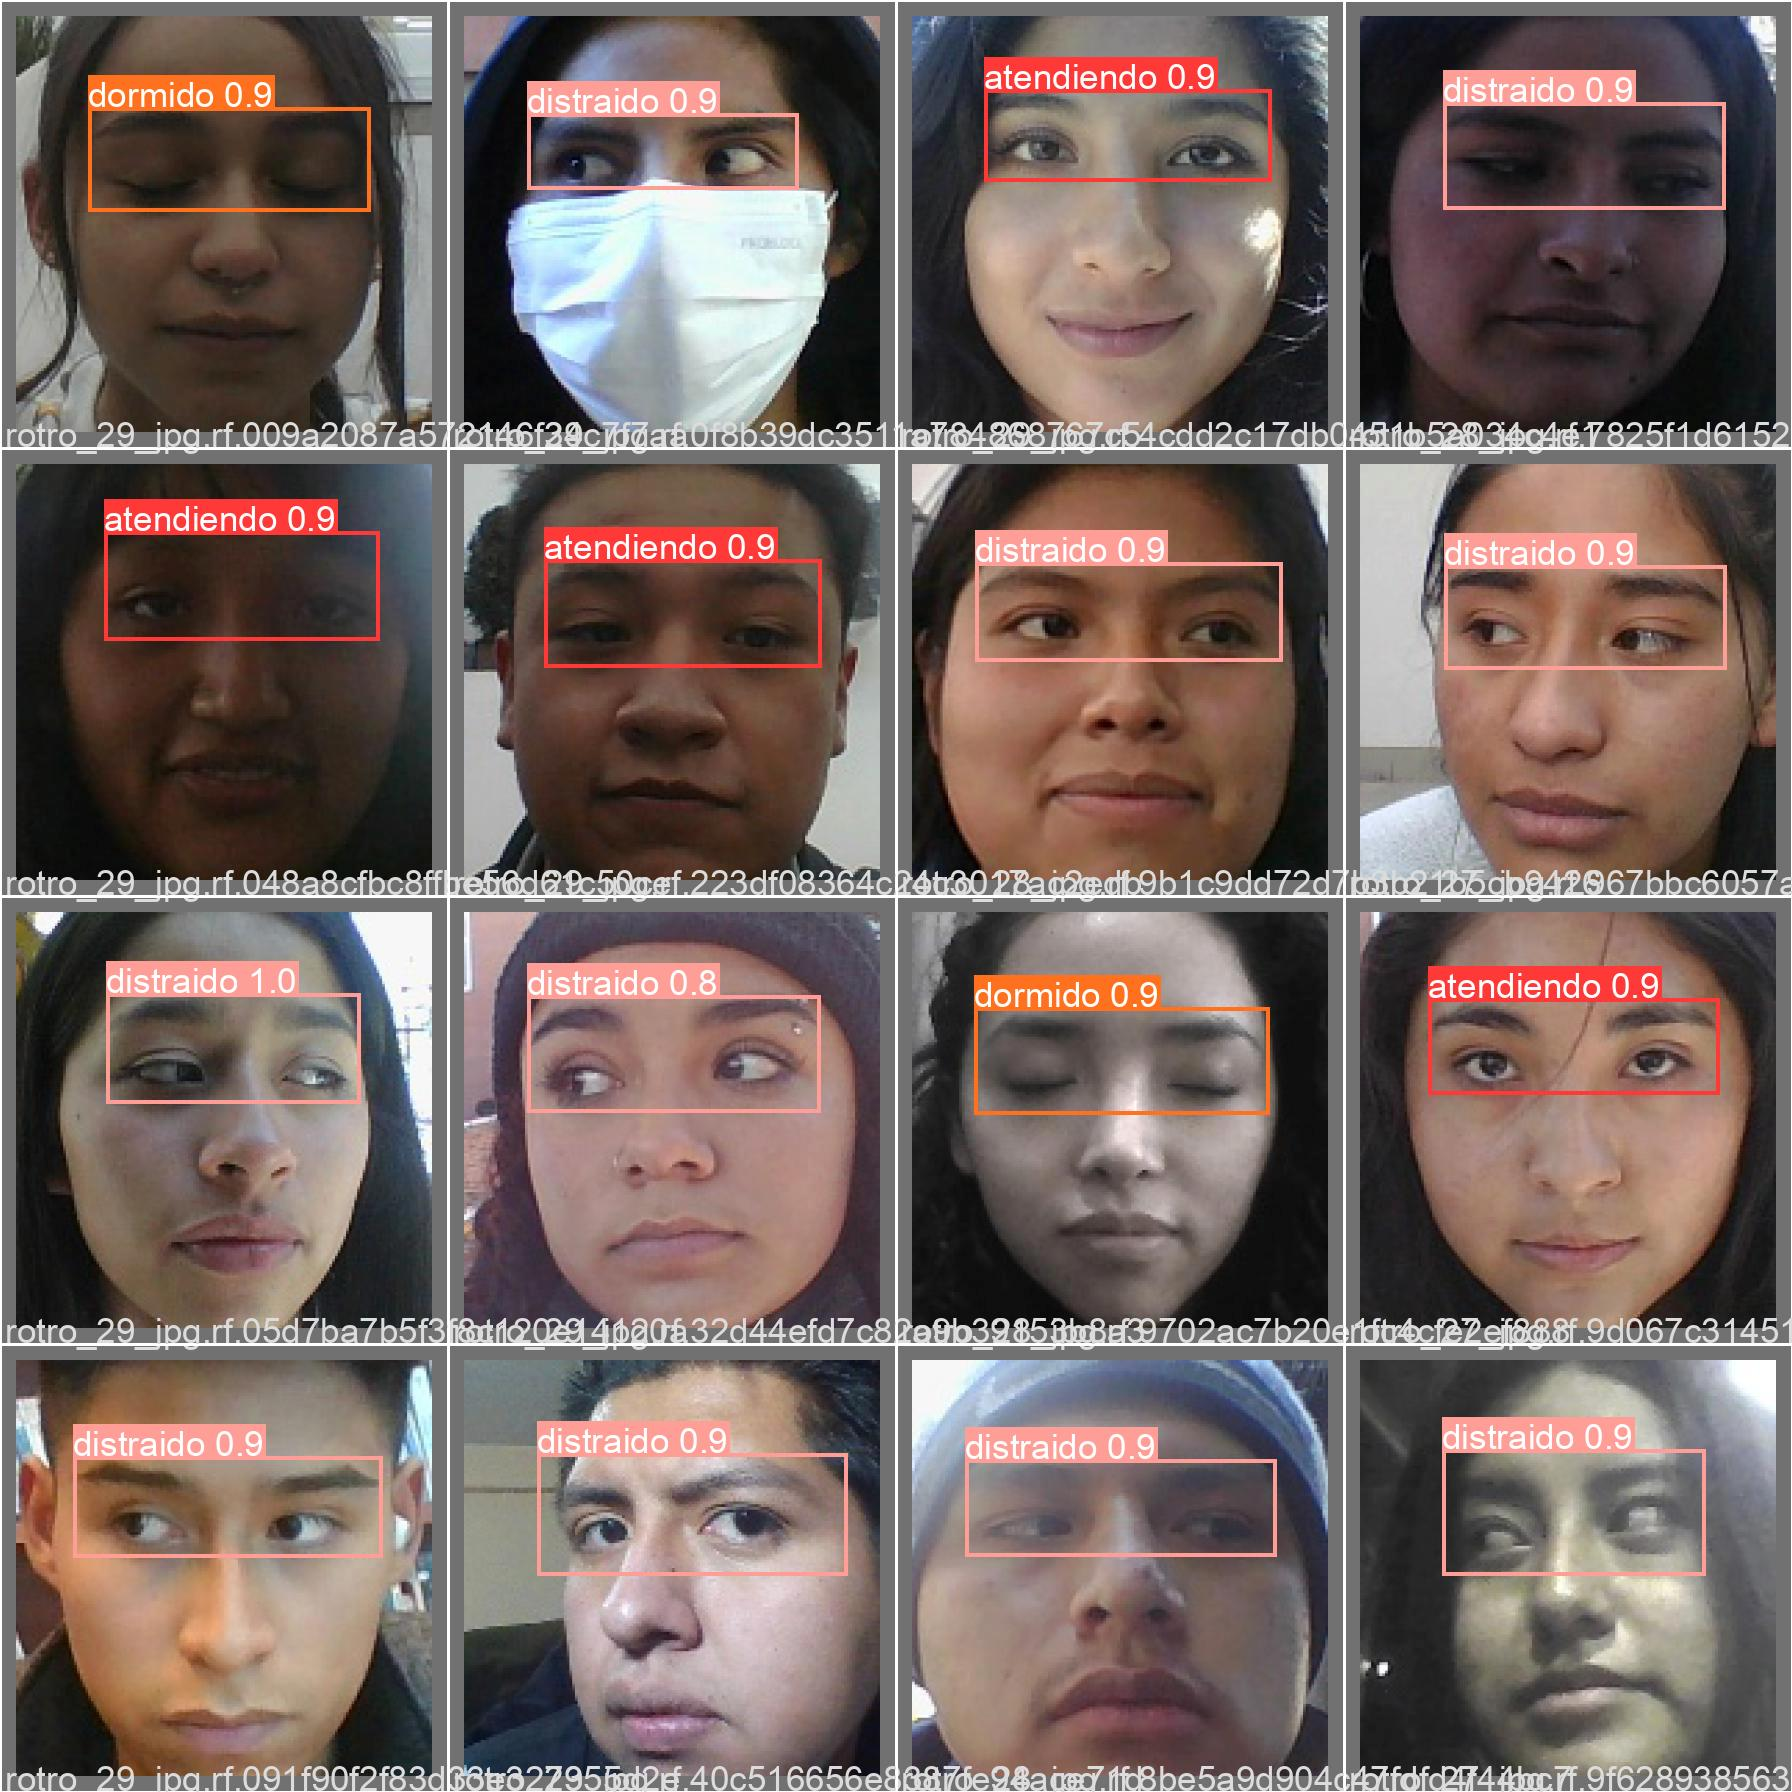

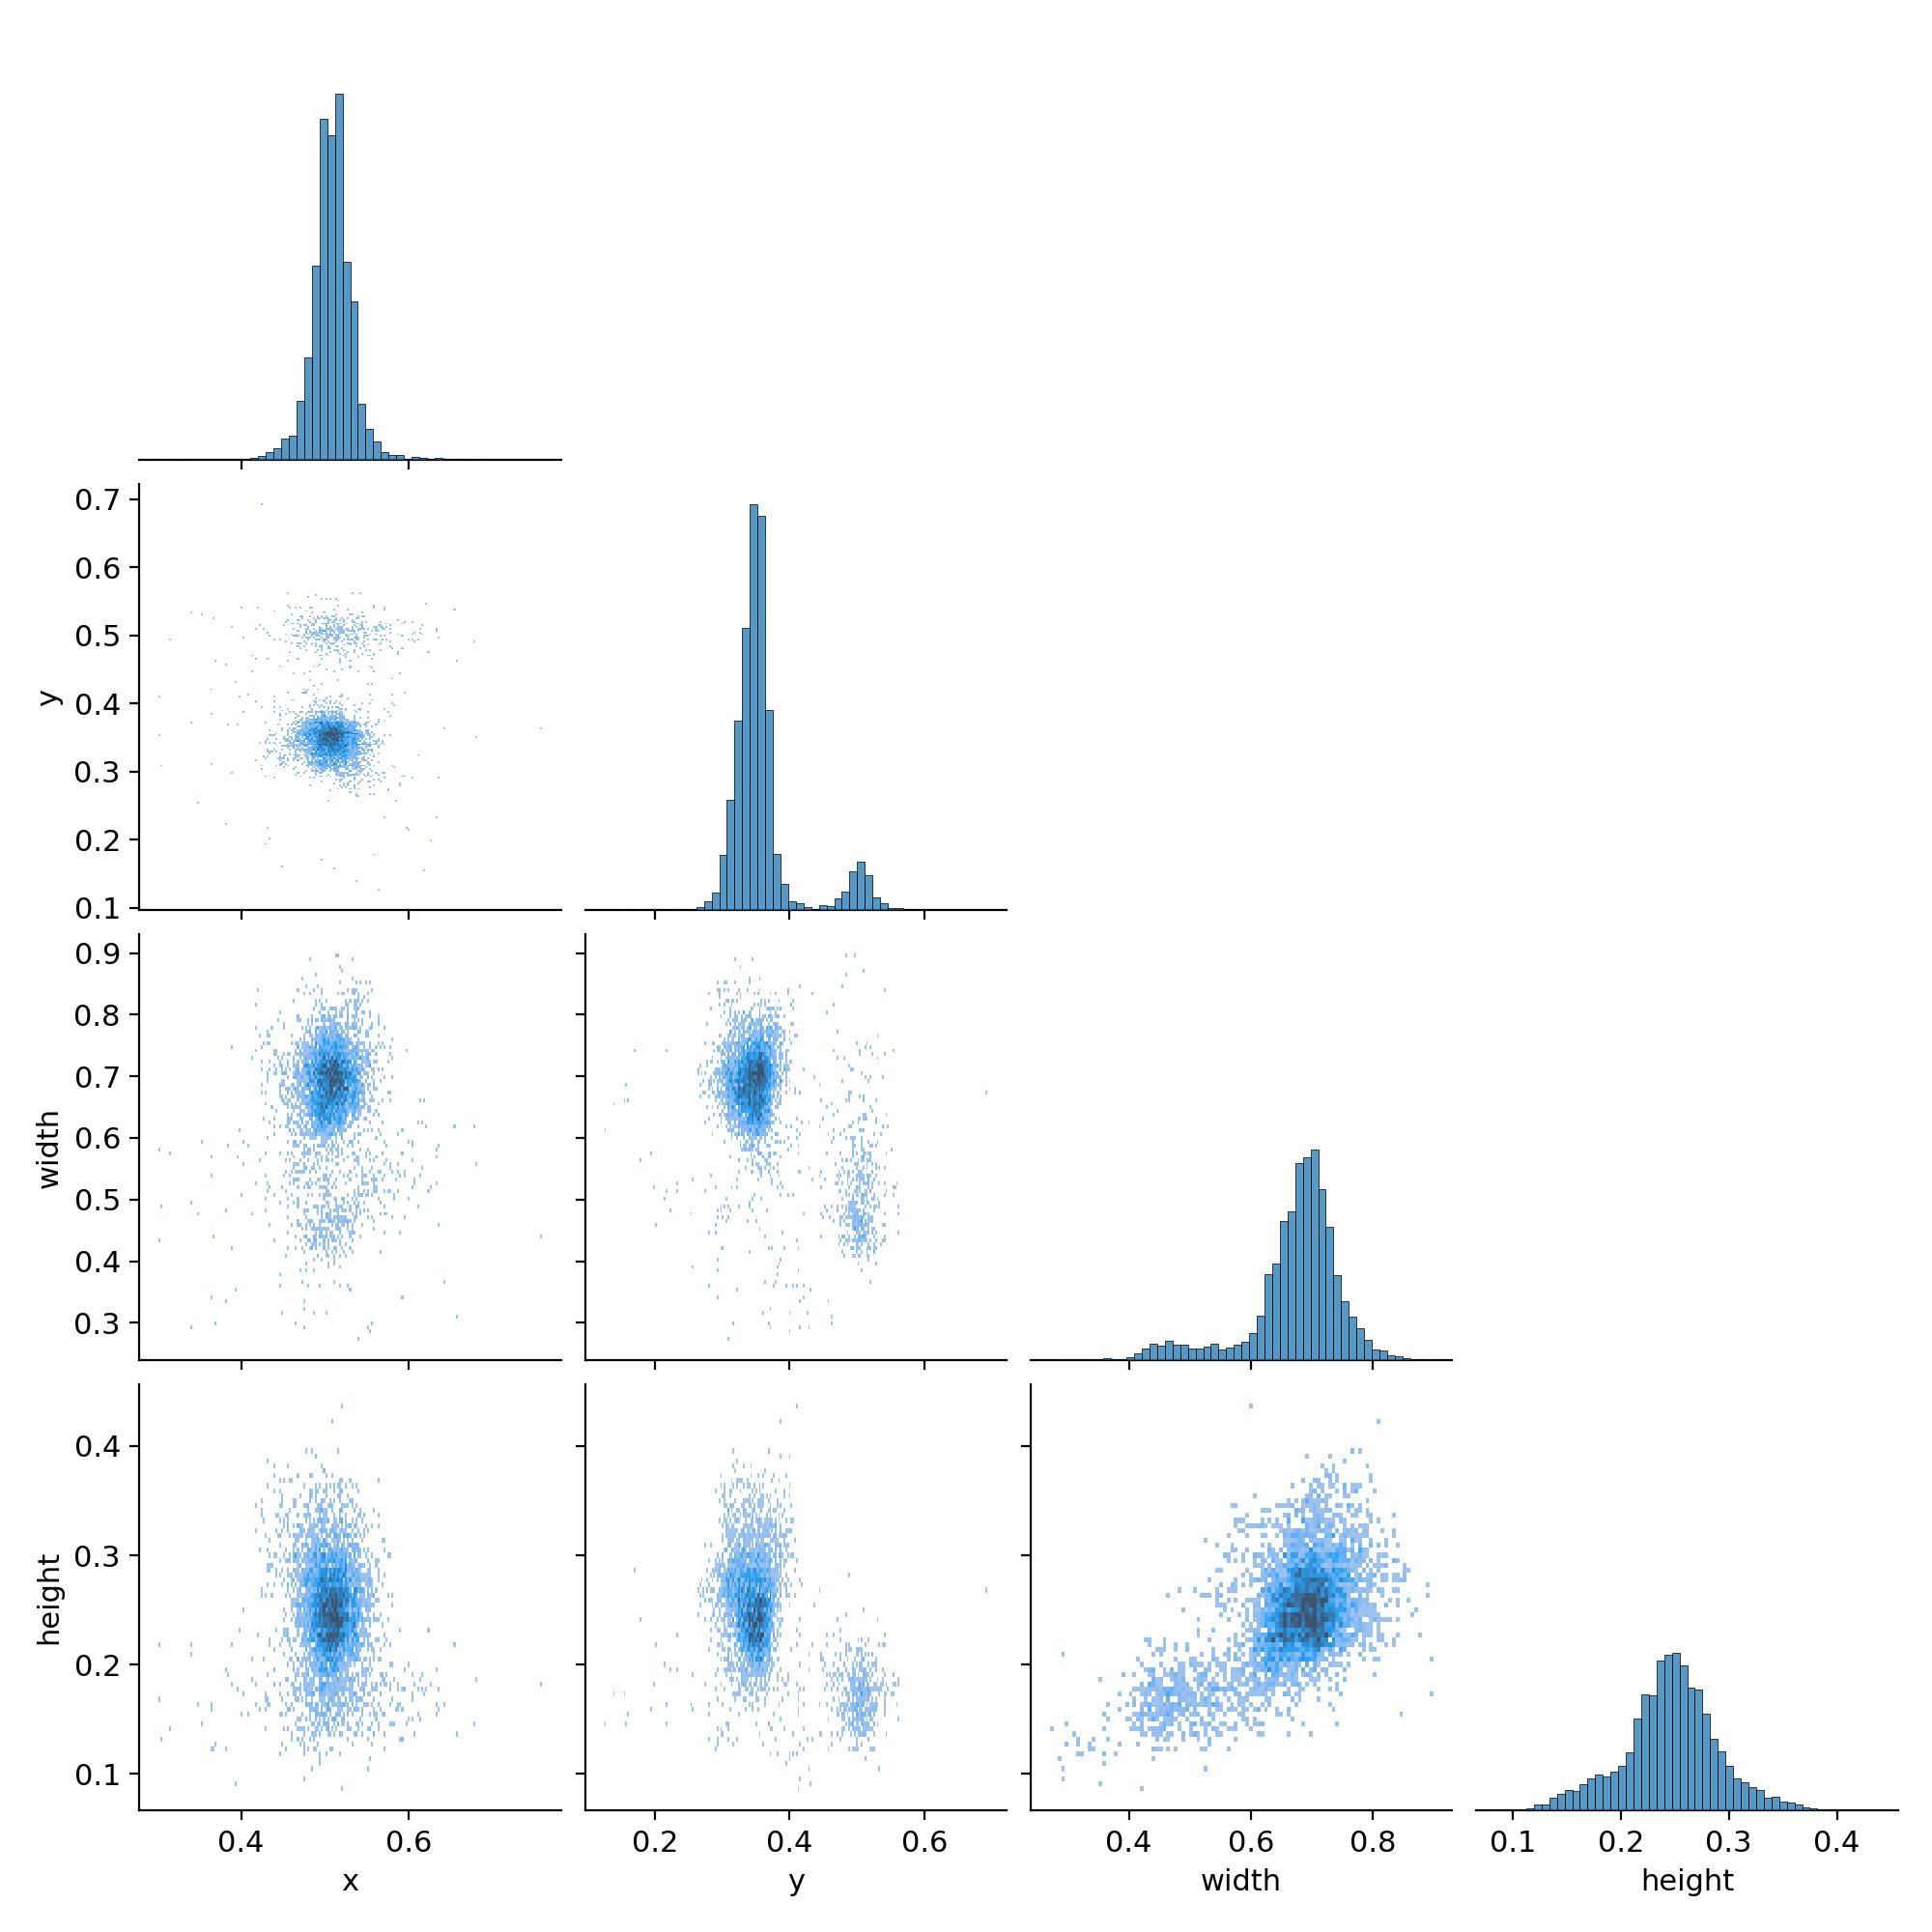

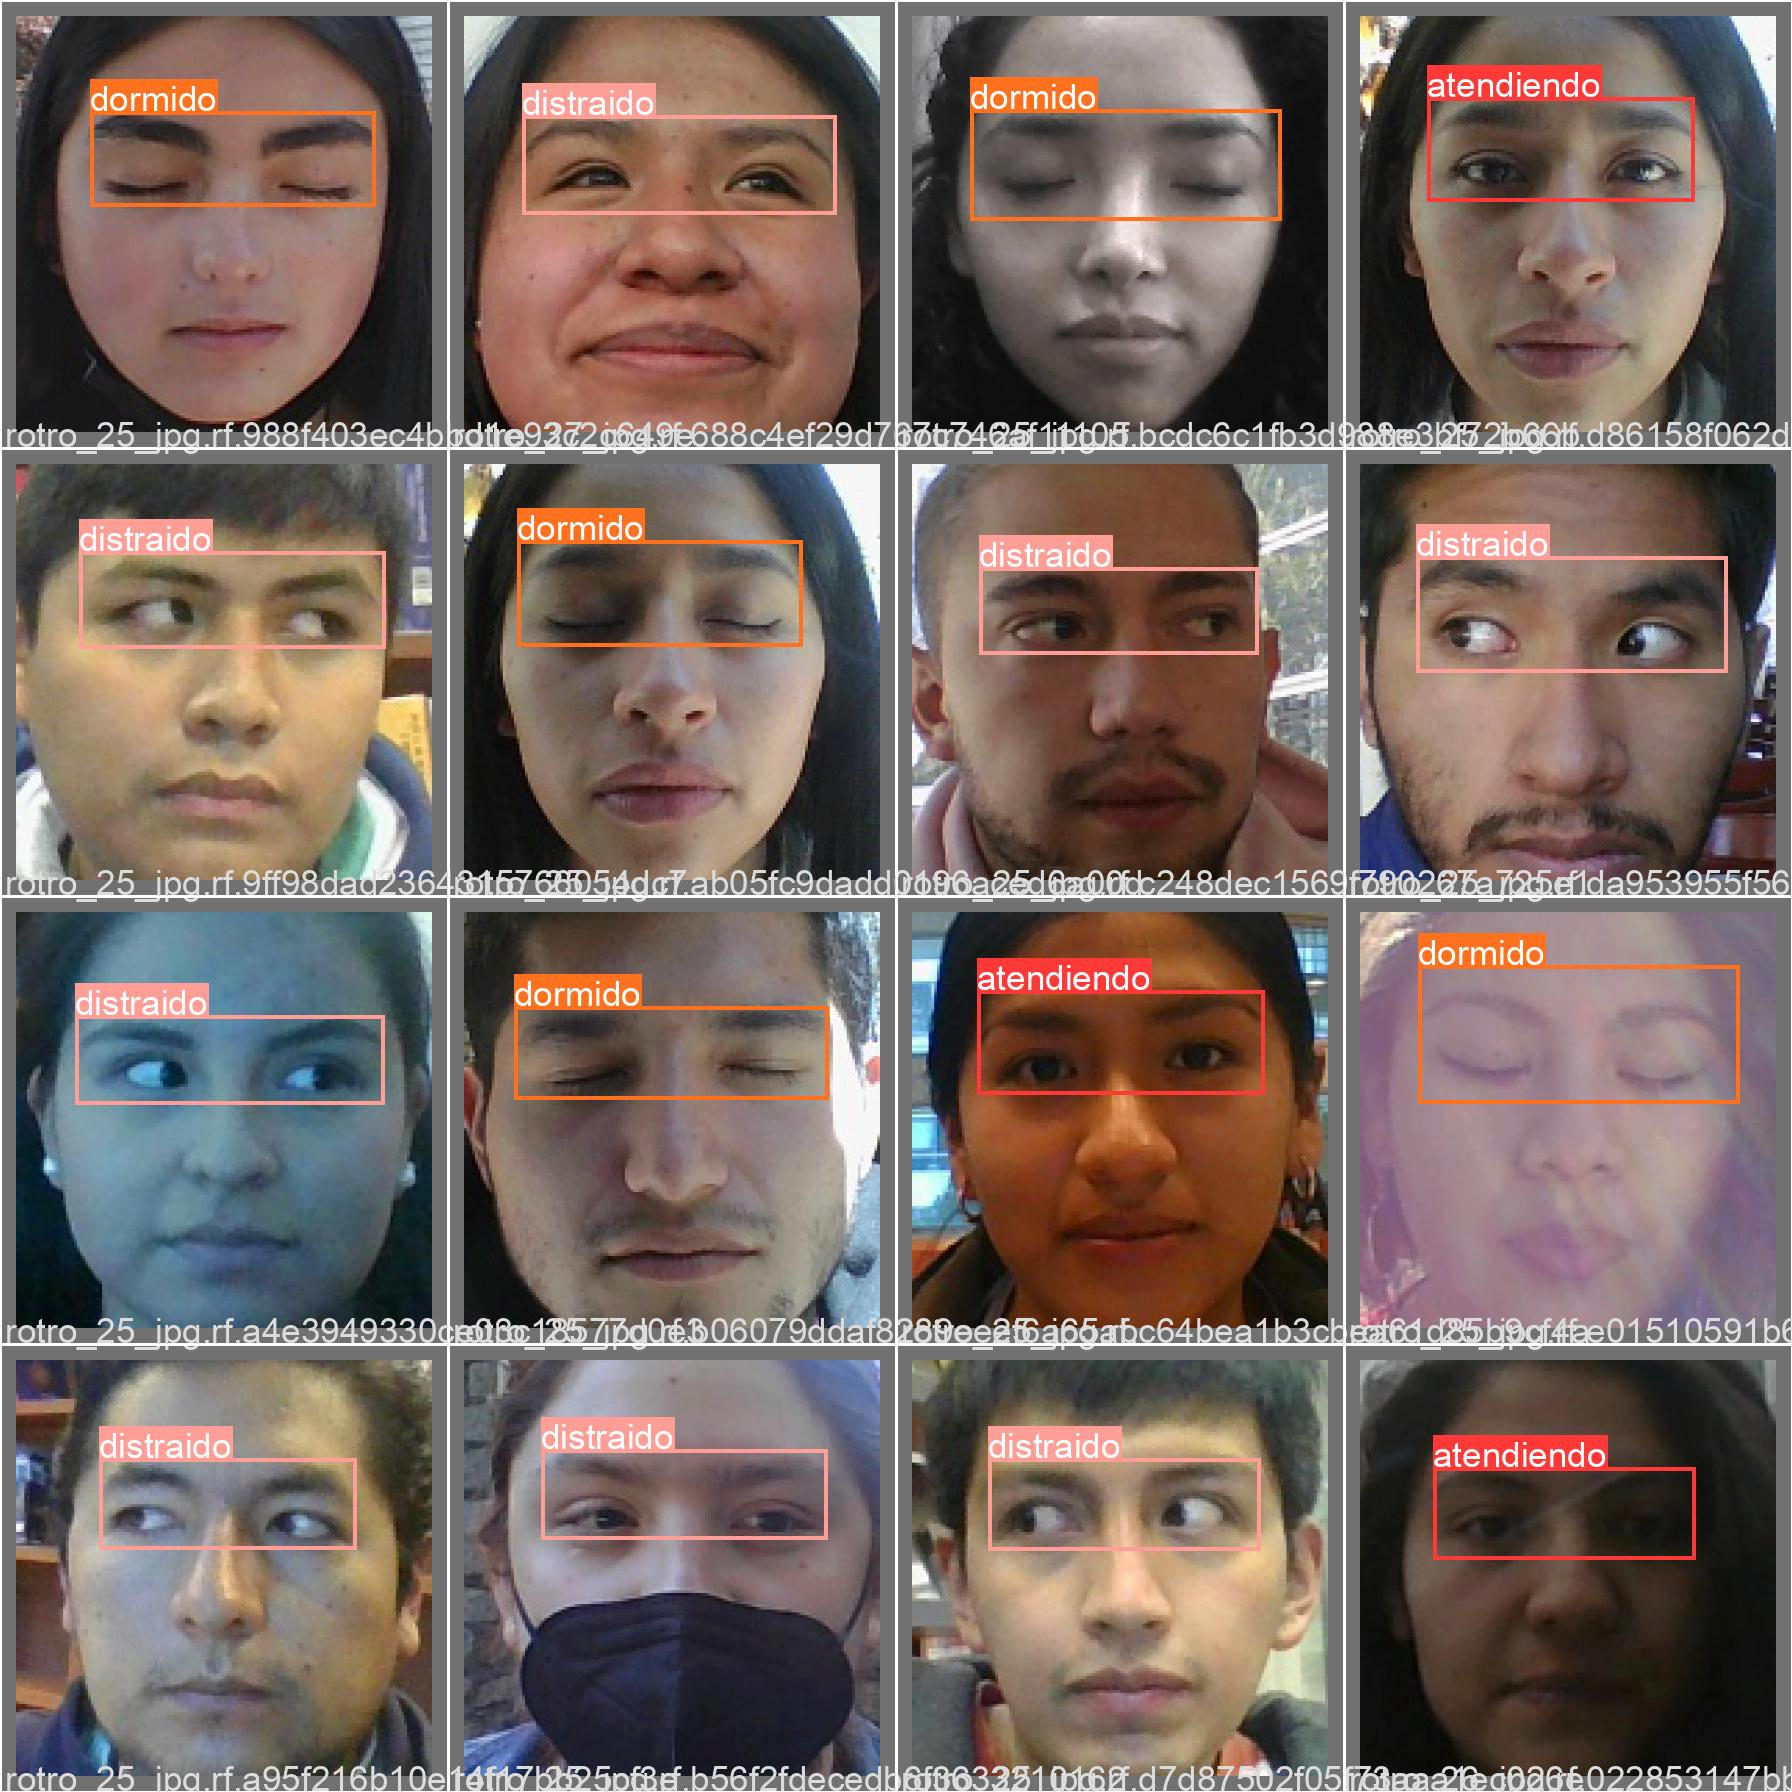

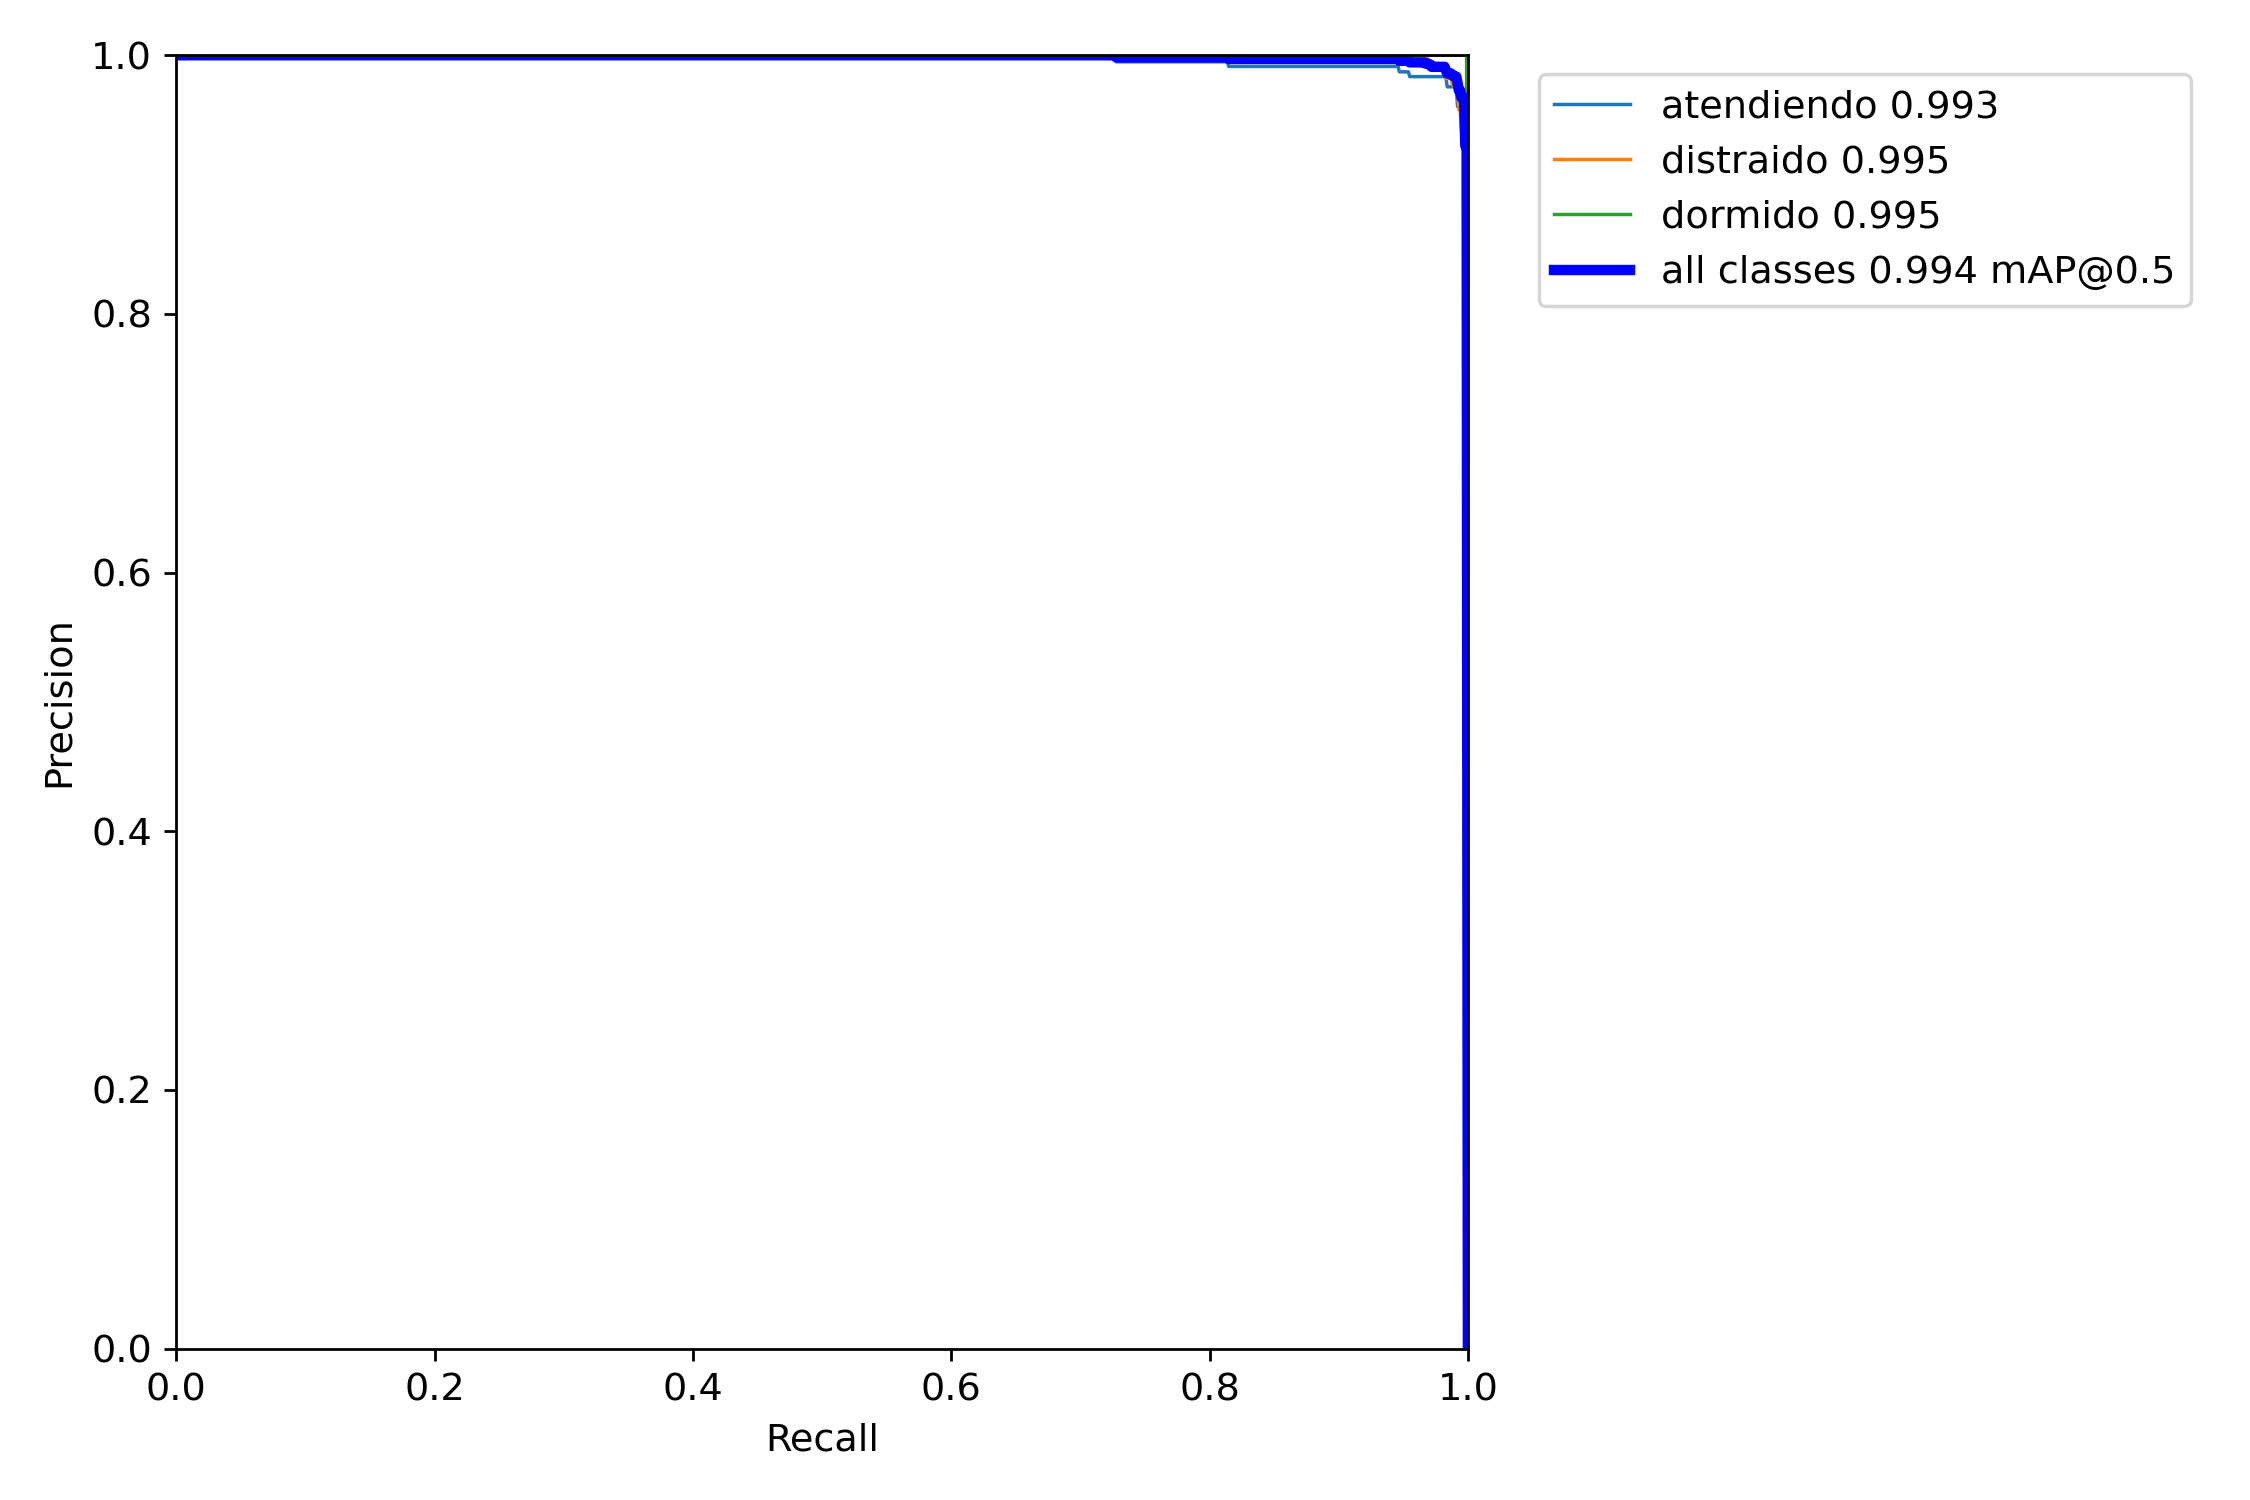

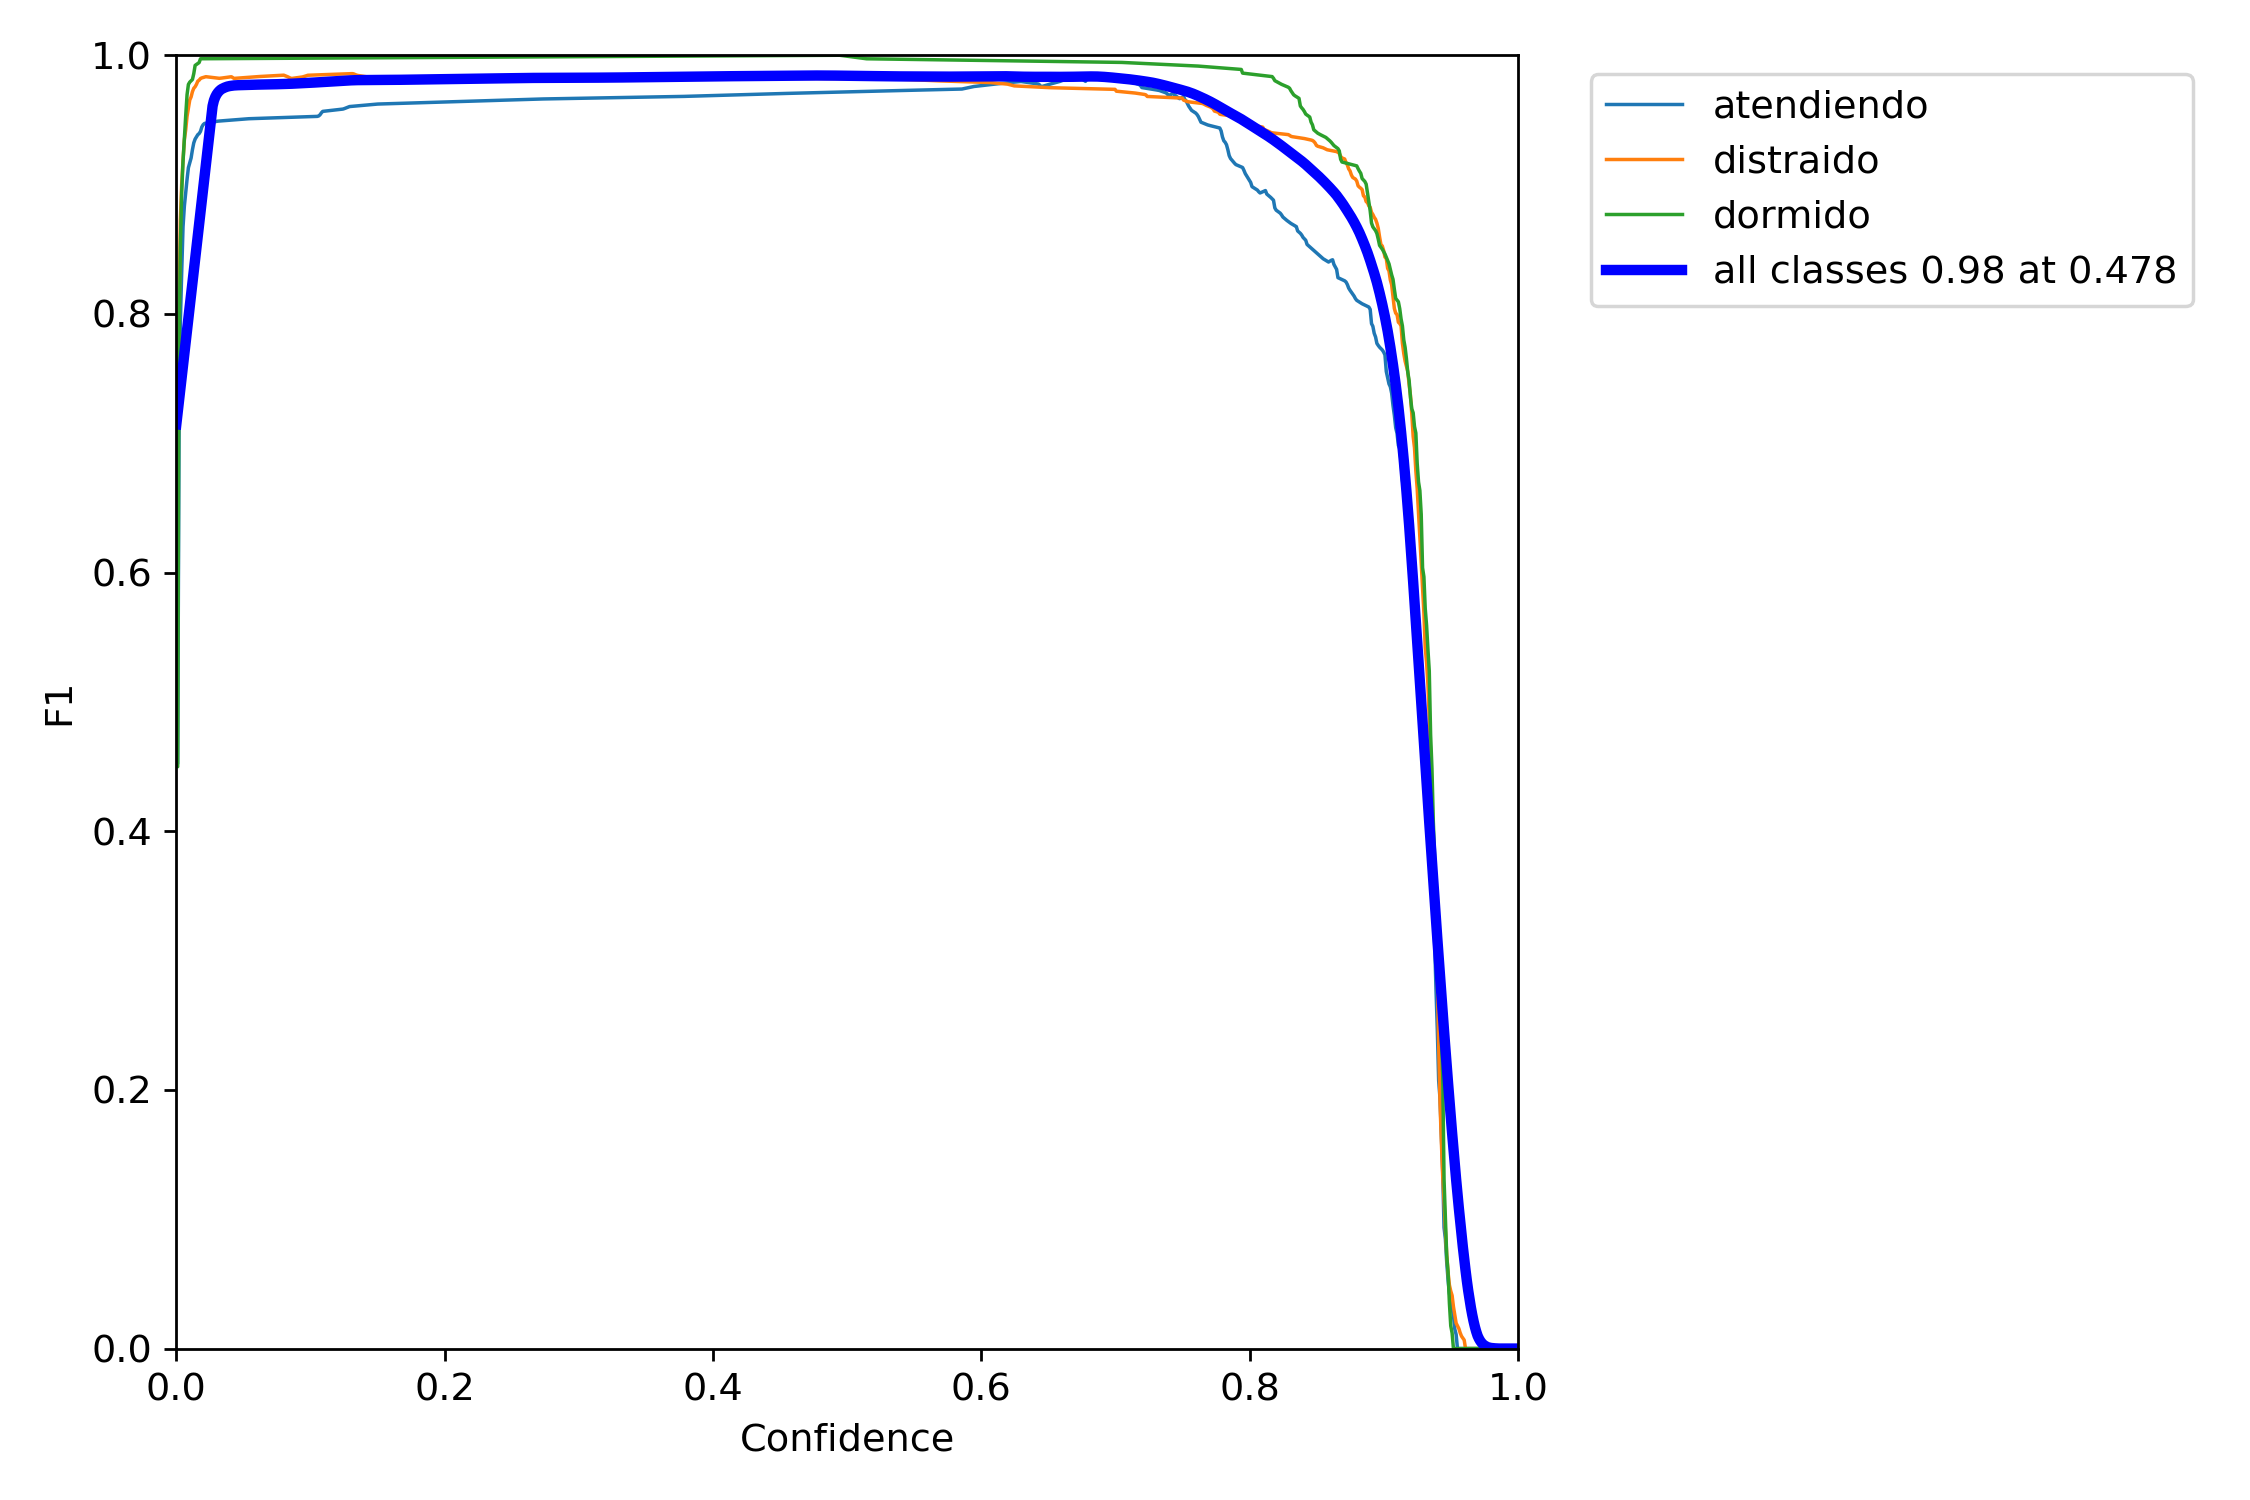

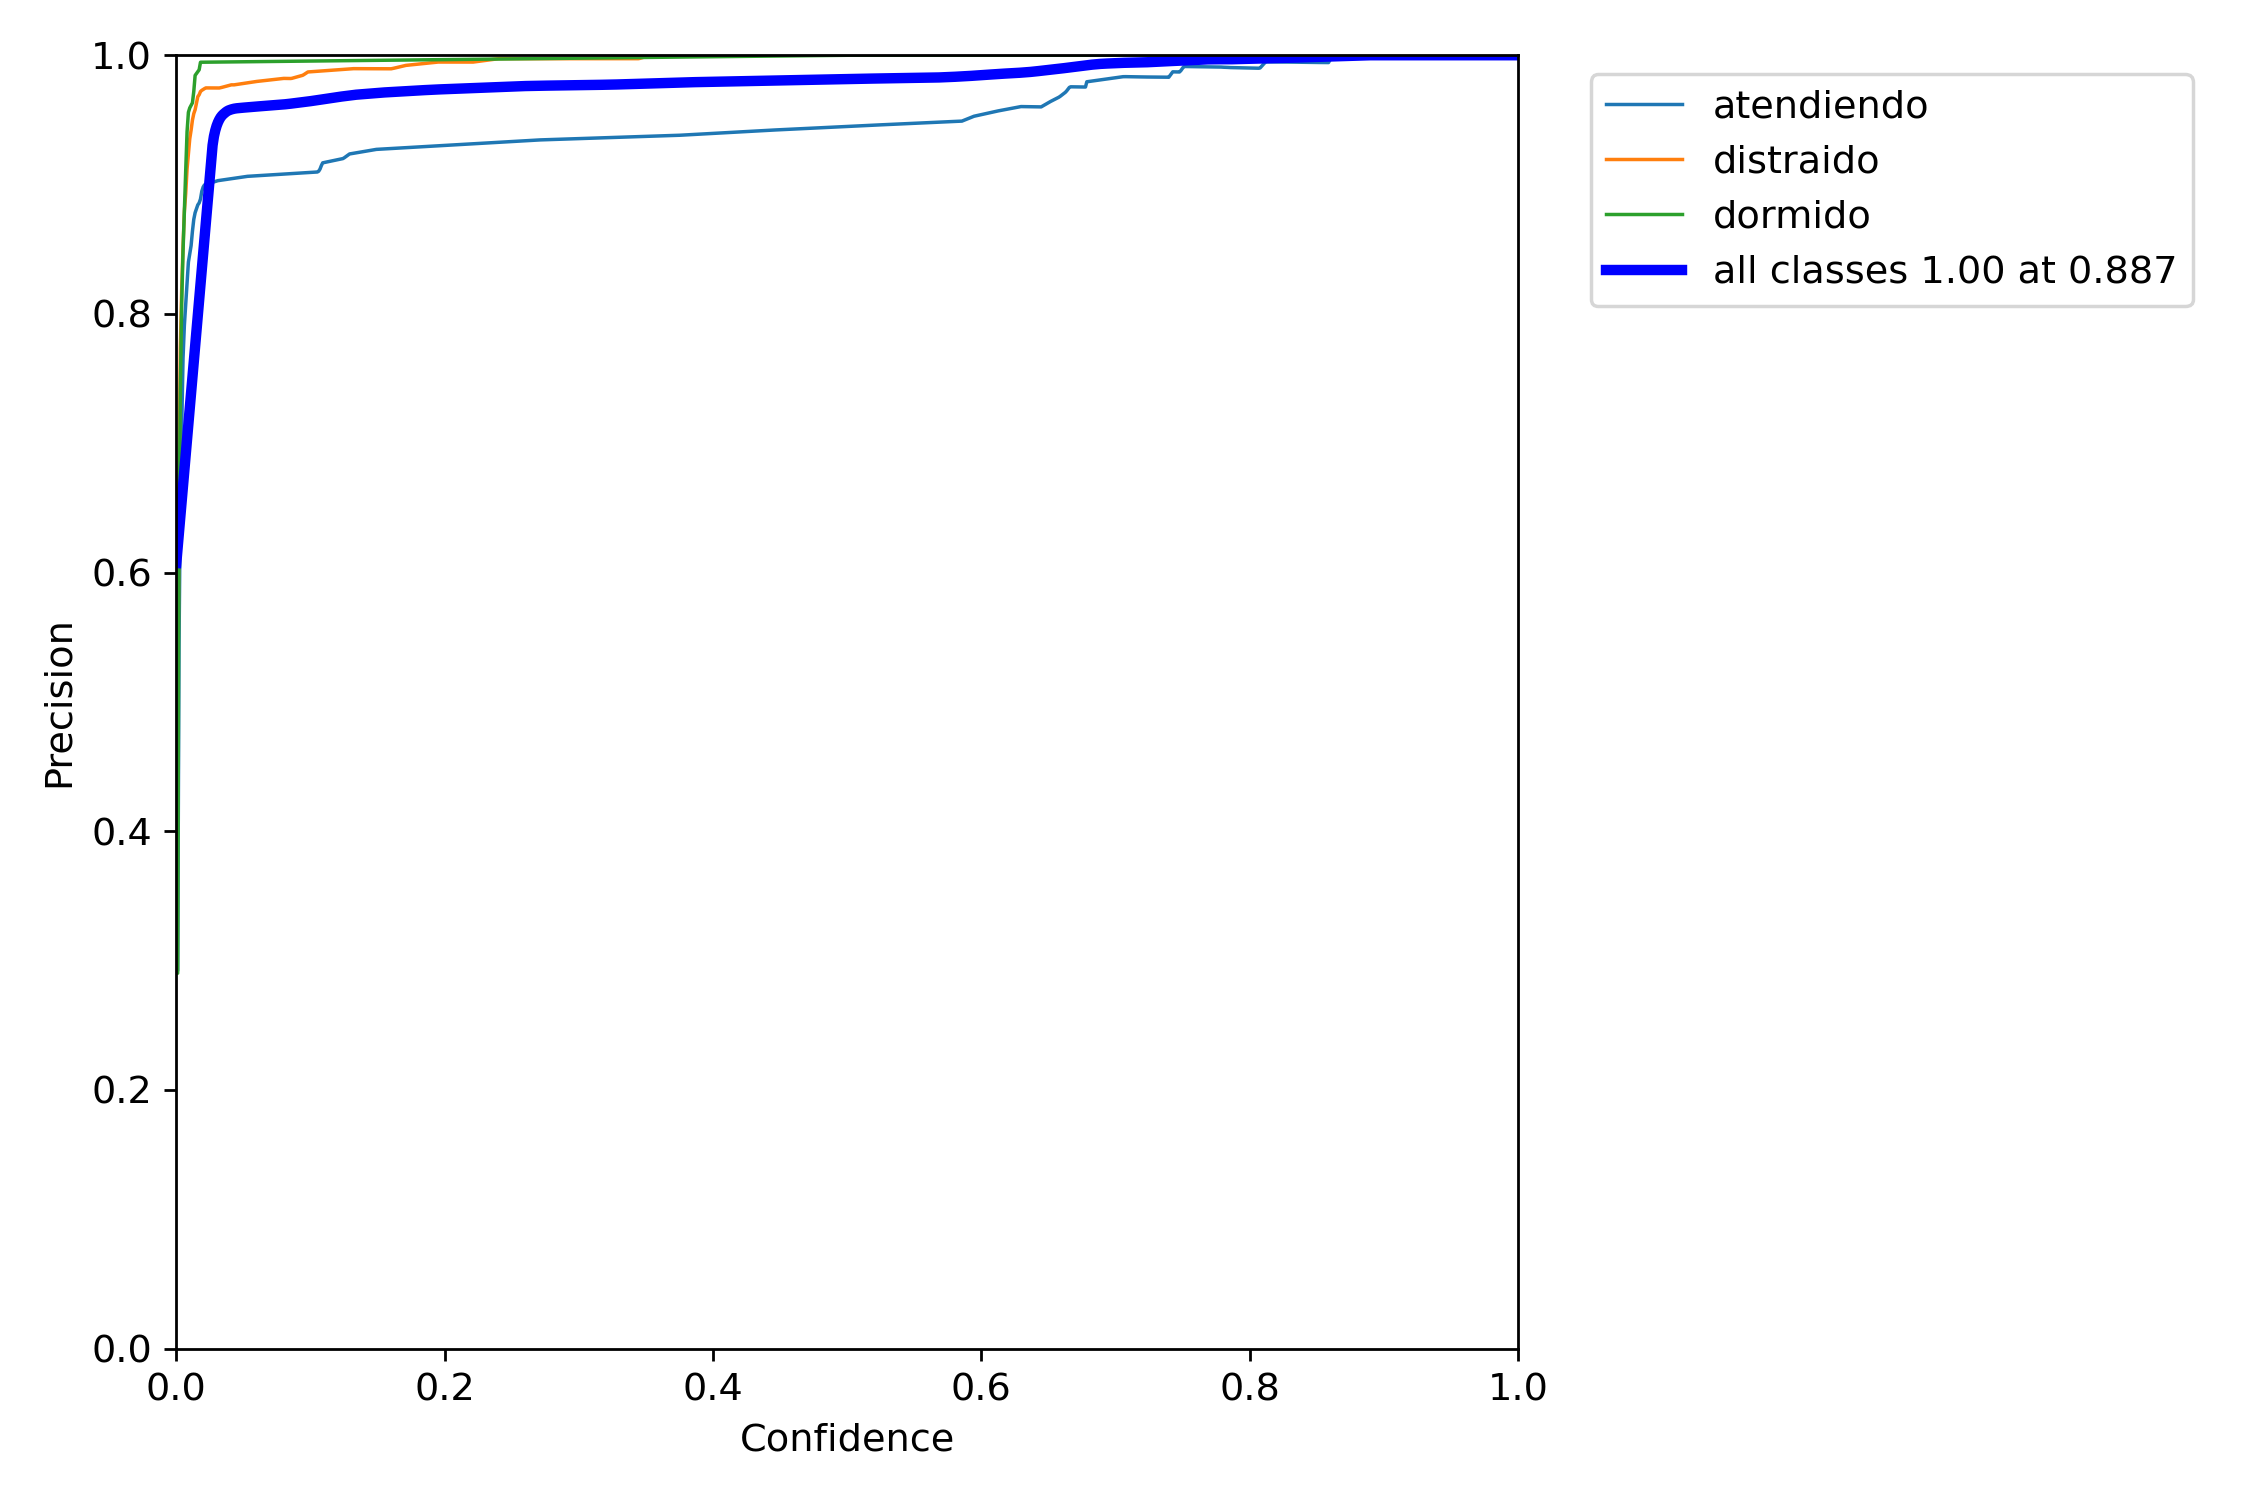

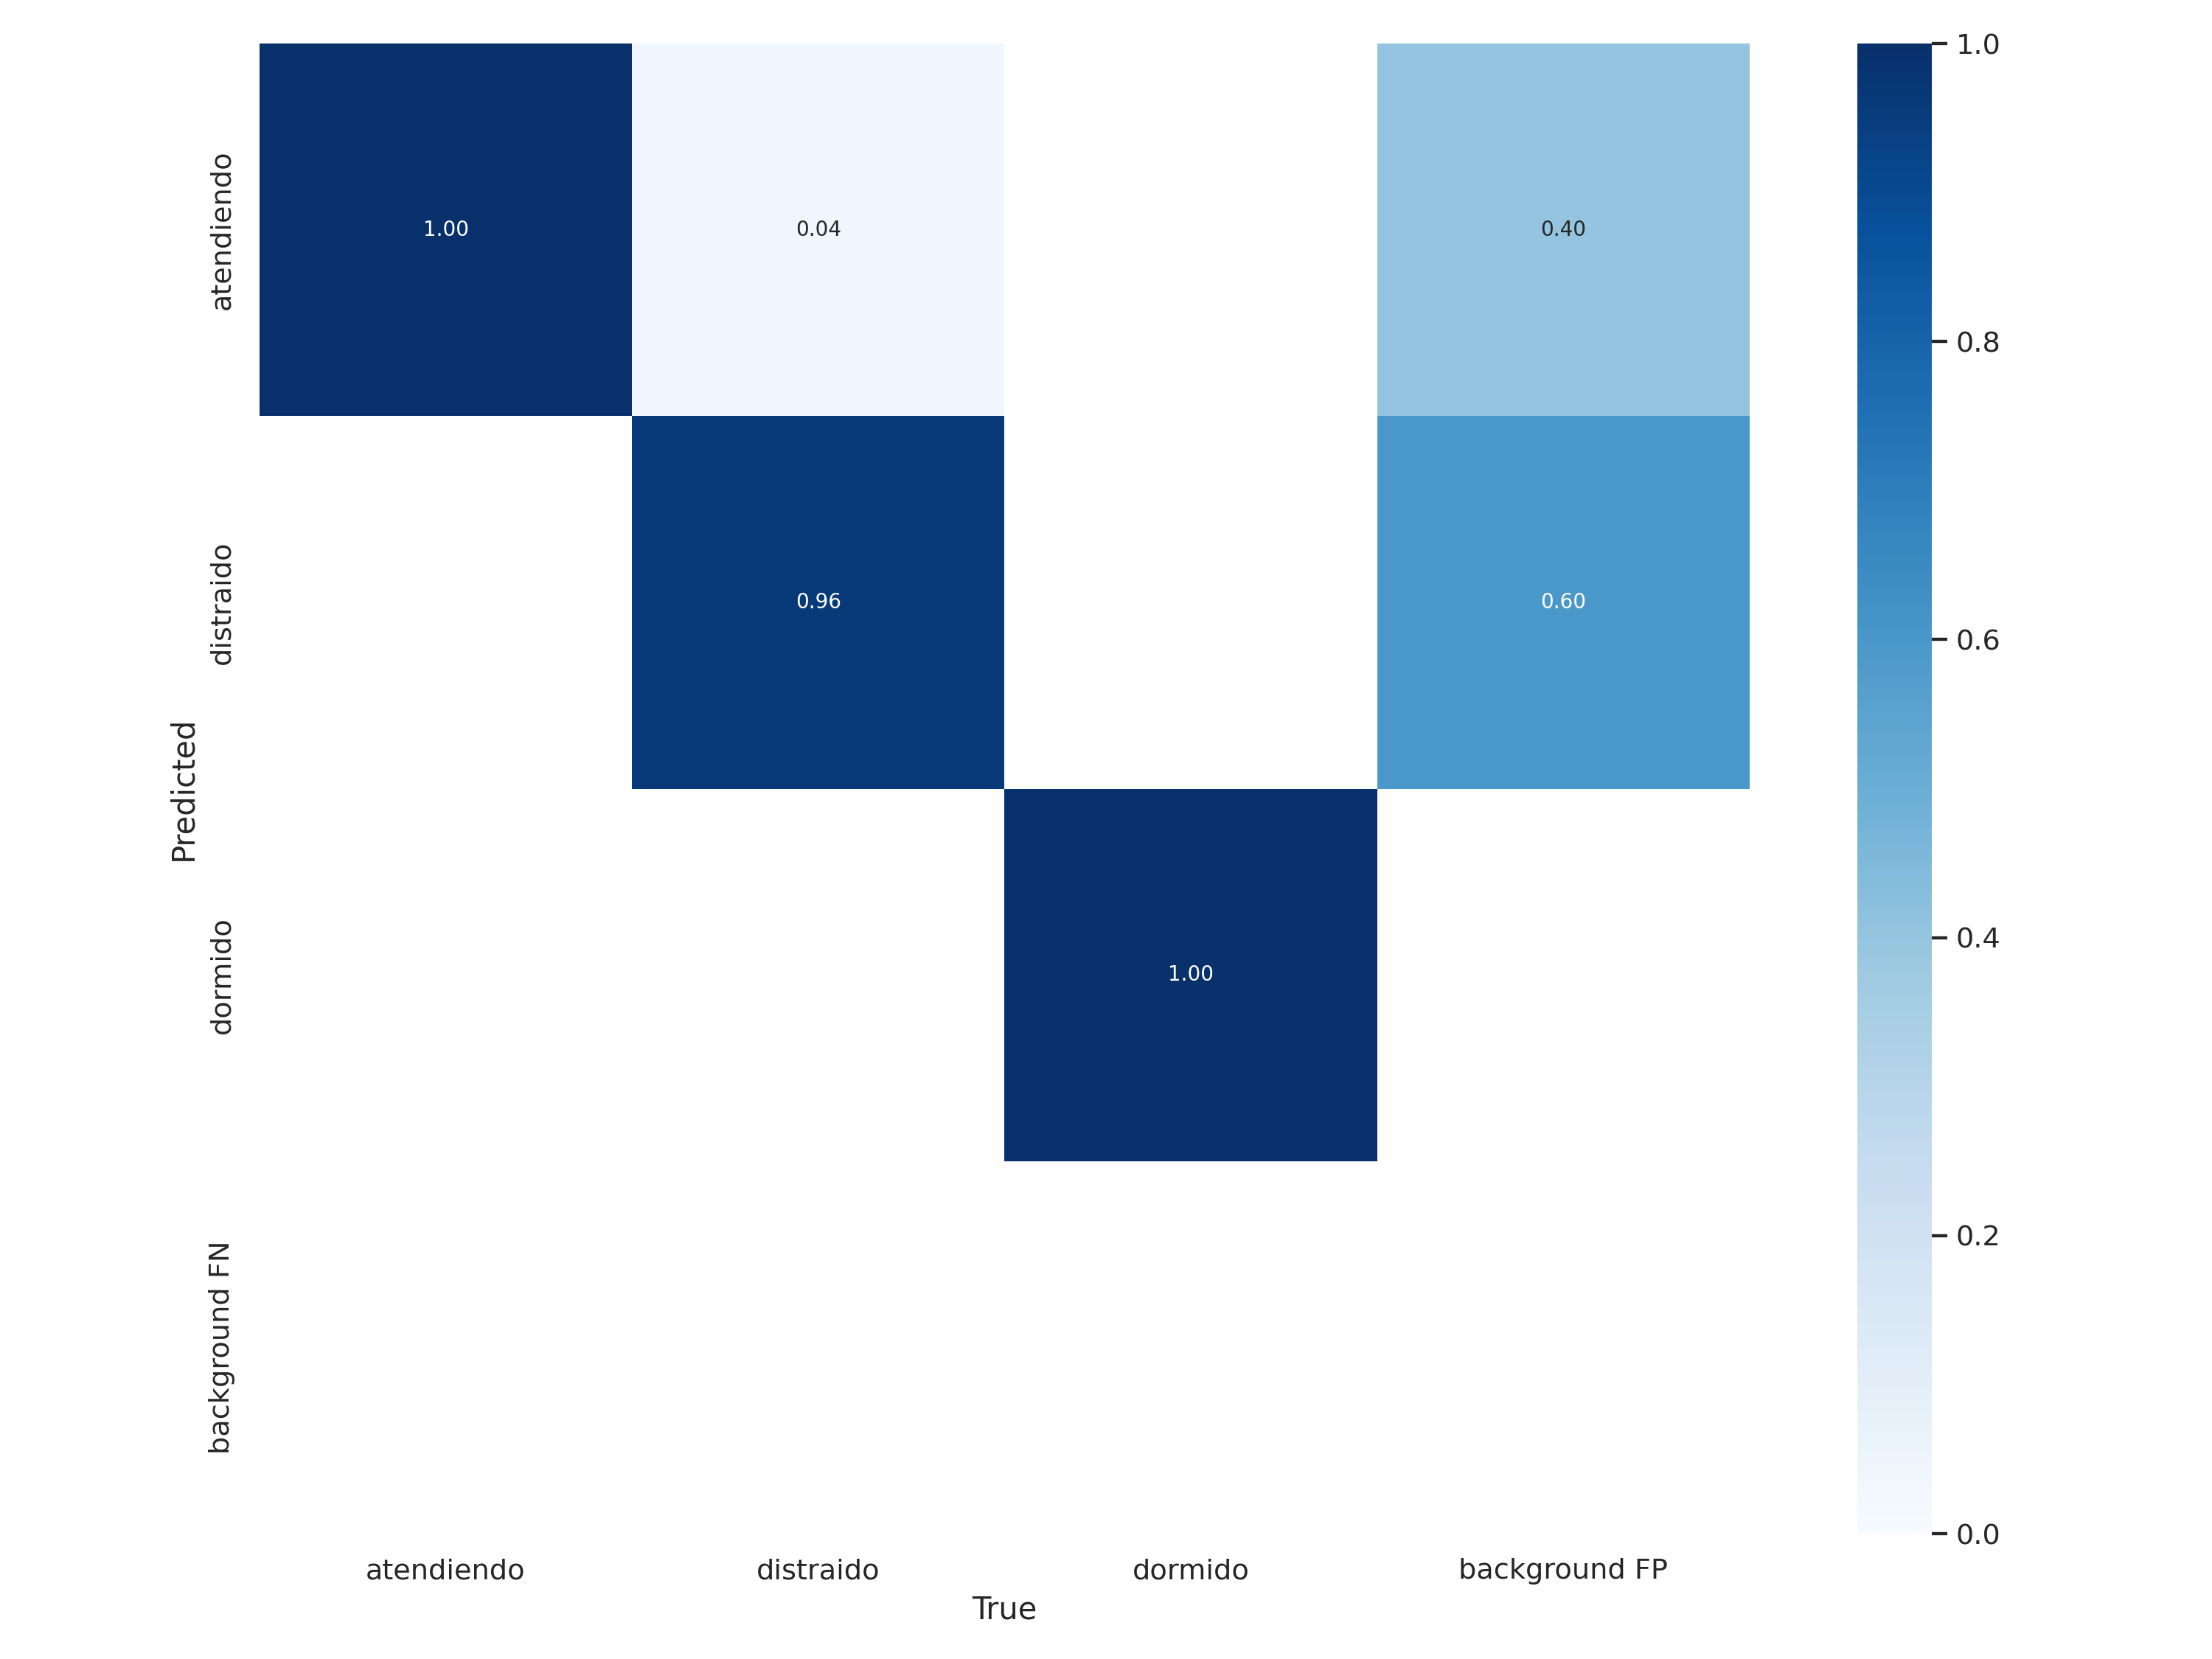

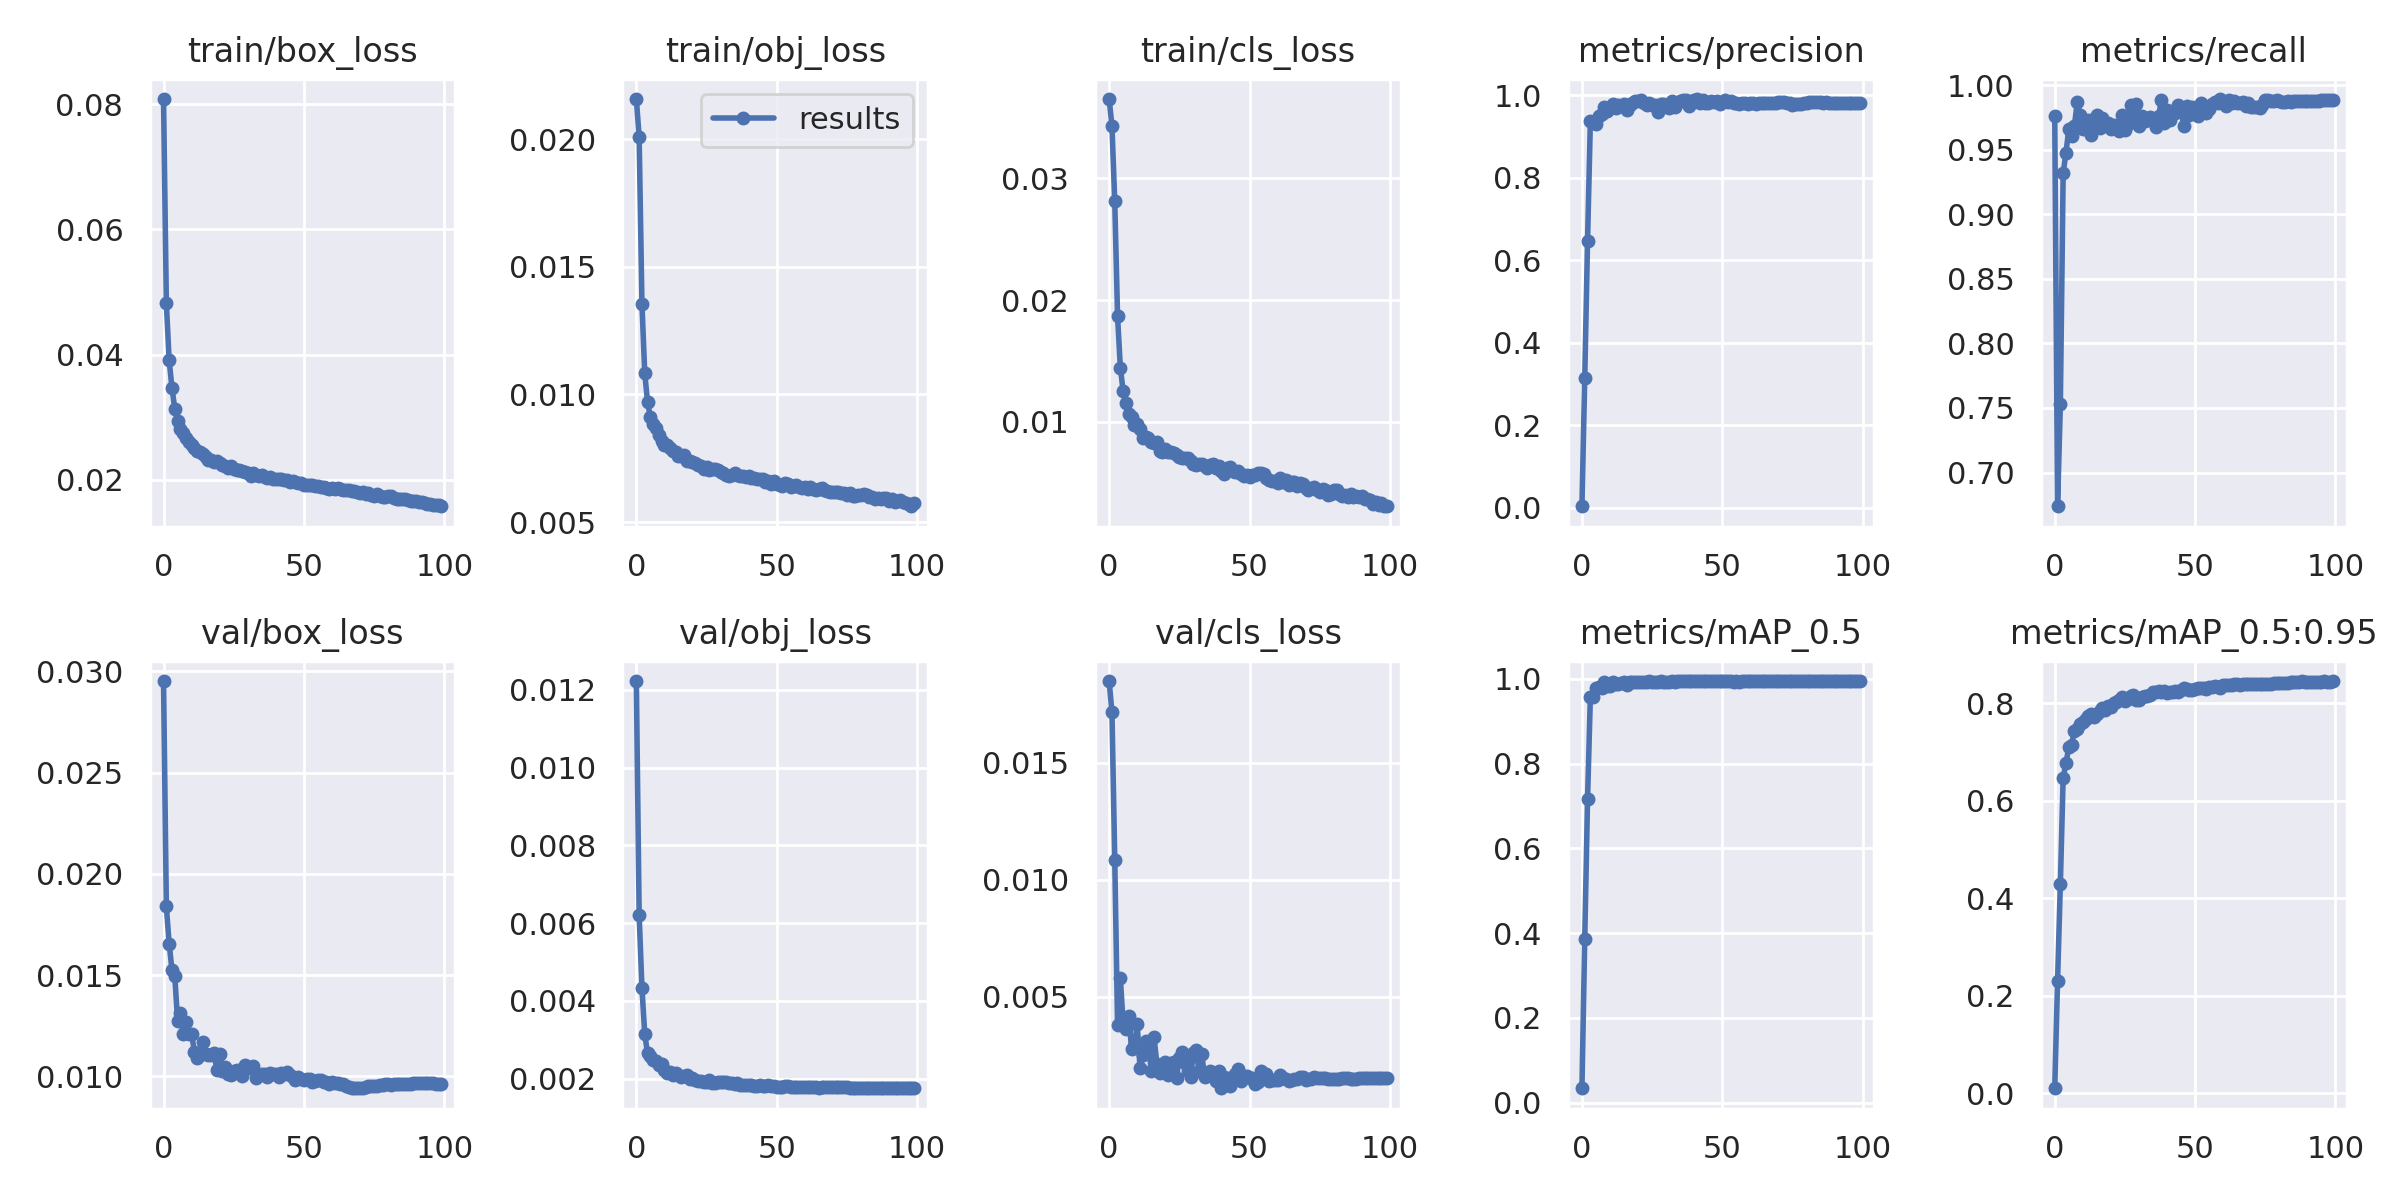

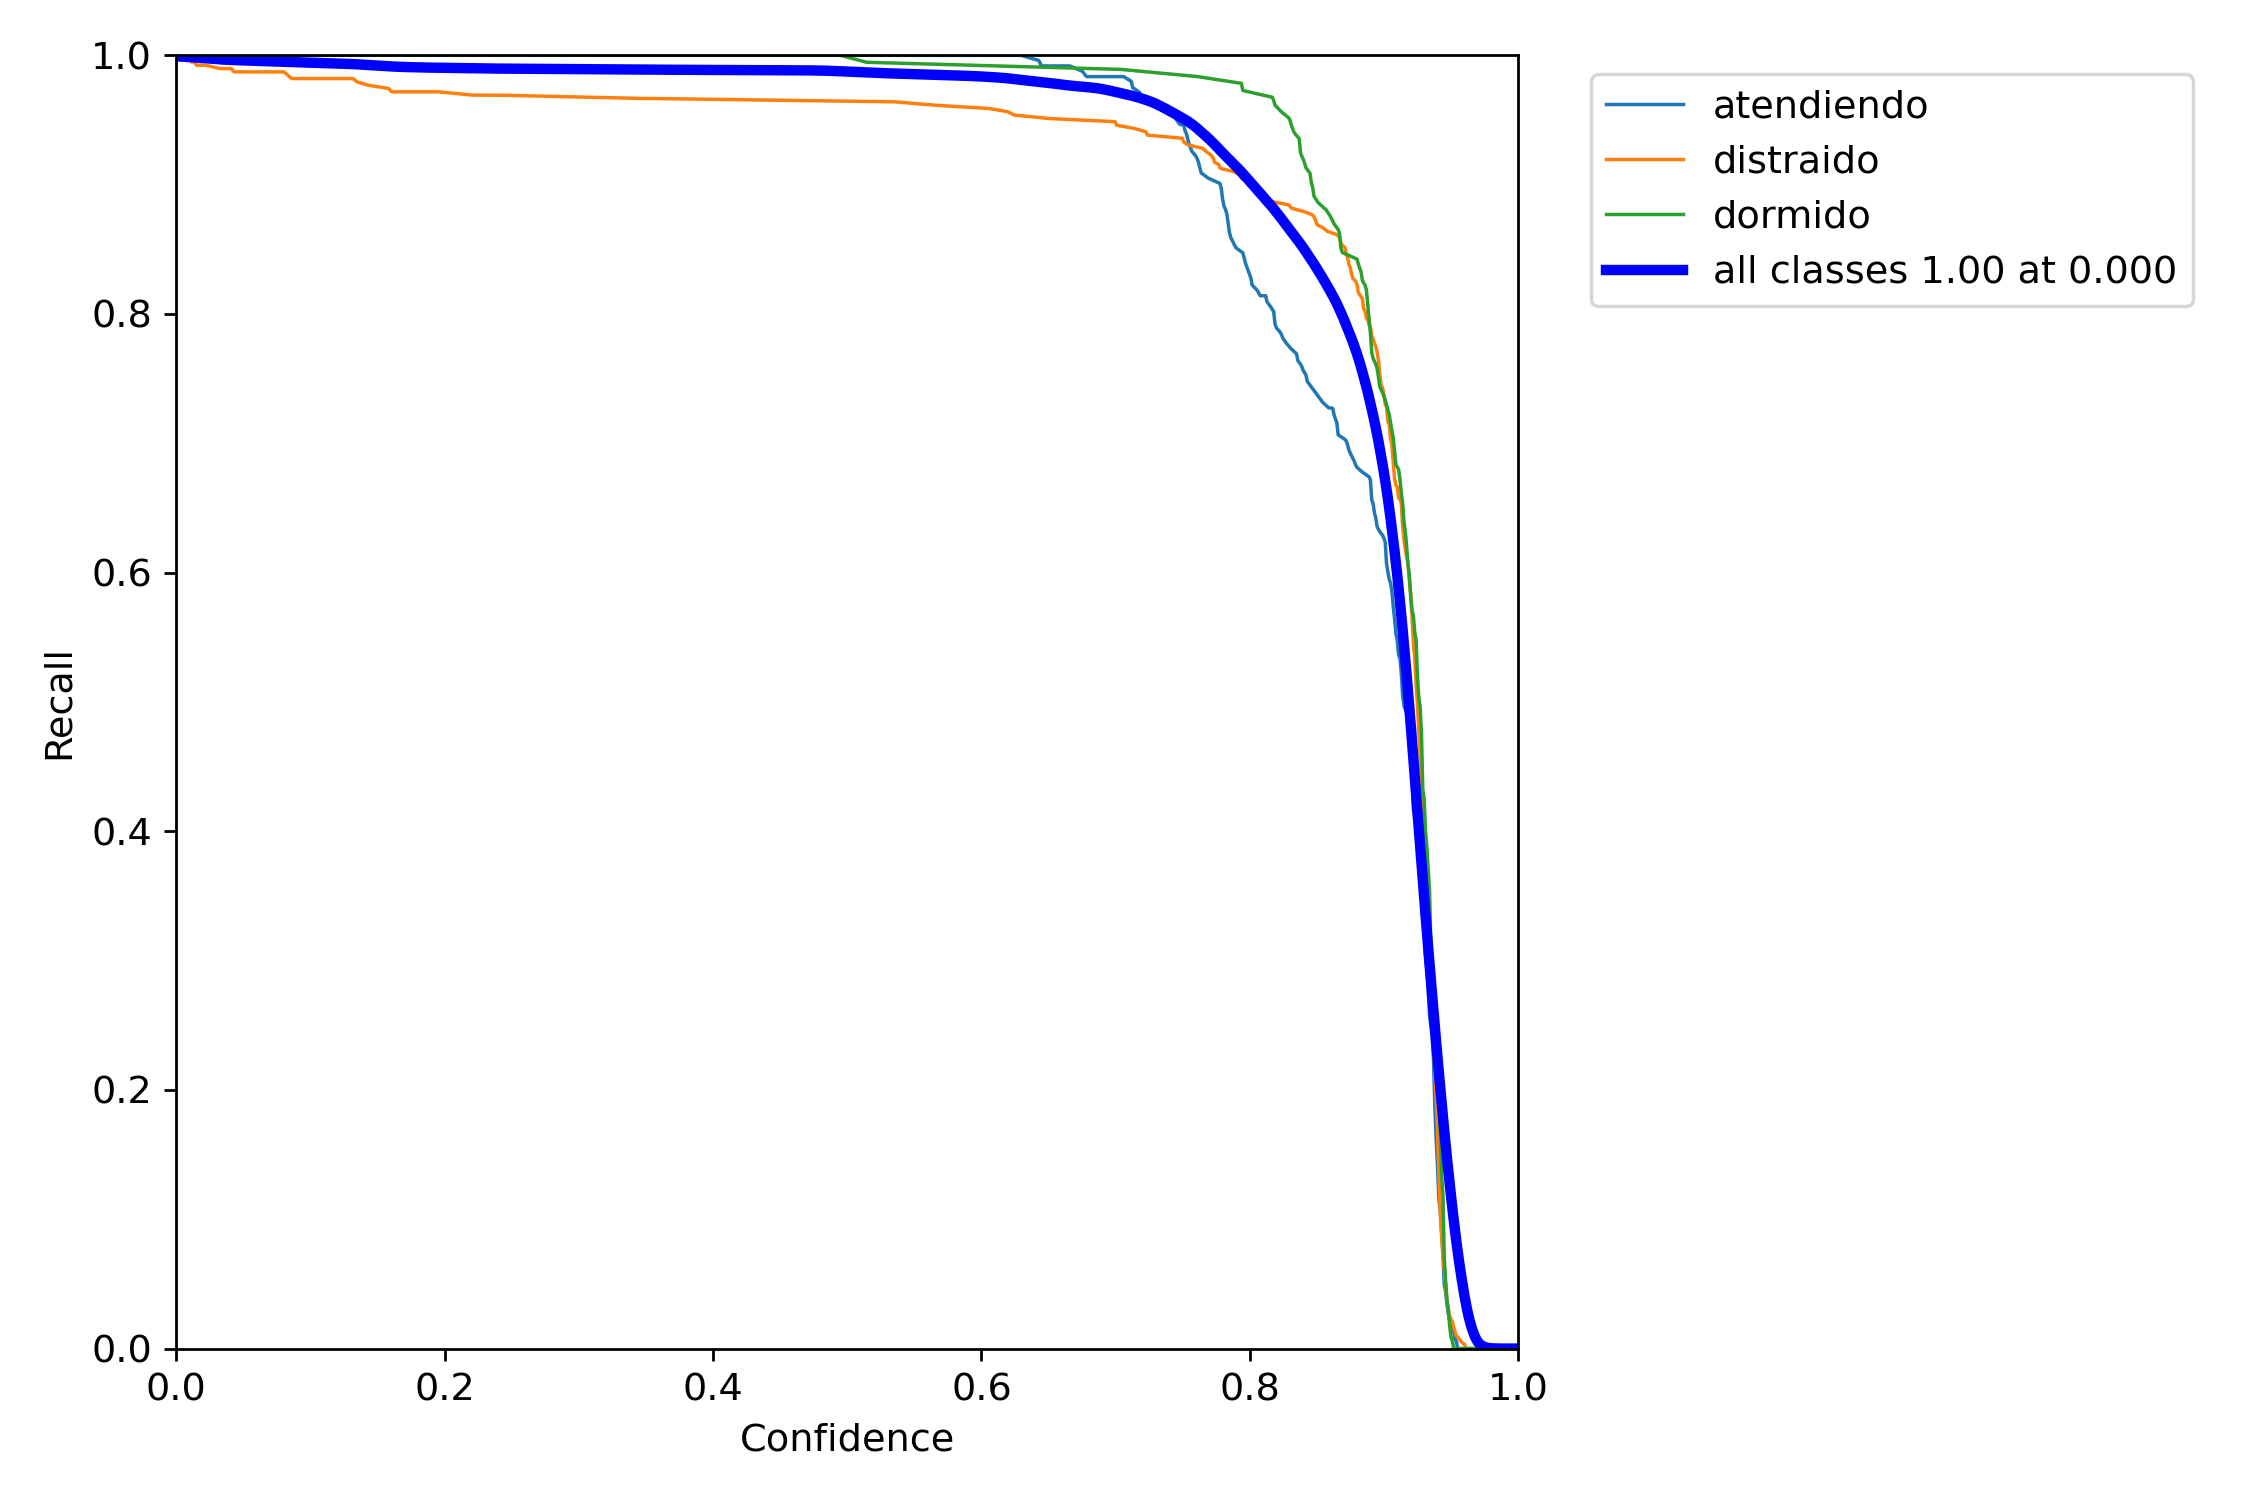

In [35]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/train/yolov5s_results/*.jpg')[:25]:
    display(Image(filename=image))
    print("\n")
  
for image in glob.glob('/content/yolov5/runs/train/yolov5s_results/*.png')[:25]:
    display(Image(filename=image))
    print("\n")